In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

# 1. Business Problem 

## 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

##1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

#2. Machine Learning Probelm </h1>

## 2.1 Data </h2>

### 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

### 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

## 2.2 Mapping the real world problem to an ML problem </h2>

### 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

### 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

## 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

#3.Exploratory Data Analysis

In [ ]:
file_path = "/content/drive/MyDrive/Applied AI Assignments/LN Assignments/Case Study 1 Quora question pair/"

#"/content/drive/MyDrive/Applied AI Assignments/case_study_1_Quora/"

In [ ]:
pip install distance

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

##3.1 Reading data and basic stats </h2>

In [ ]:
df = pd.read_csv(file_path +"original_train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [ ]:
df = df.sample(n = 100000)

In [ ]:
df.to_csv(file_path+"train.csv", index=False)

In [ ]:
df['id'].shape

(100000,)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
202876,202876,305305,305306,Do the Lynda.com app movies have DRM?,Is Lynda.com a good learning resource?,0
18754,18754,35508,35509,What should I do after bsc in chemistry honors?,What should I do after Bsc in chemistry?,0
398924,398924,532170,532171,"There’s a girl I really like, but I don't know...",Can anyone stay for one hour without blinking ...,0
360575,360575,260749,112252,What is the best app to track someone's phone ...,How can I track my friend's phone without them...,1
134012,134012,21835,38619,"How can we use the word ""contorted"" in a sente...","How do you use the word ""bravado"" in a sentence?",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 202876 to 326092
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     99999 non-null   object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

###3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

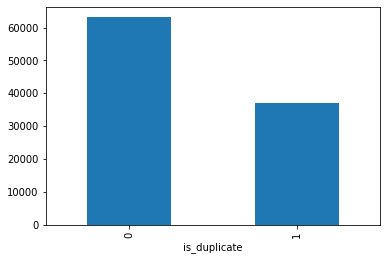

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   100000


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.09%

~> Question pairs are Similar (is_duplicate = 1):
   36.91%


###3.2.2 Number of unique questions </h3>

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 166373

Number of unique questions that appear more than one time: 19262 (11.577599730725538%)

Max number of times a single question is repeated: 38



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



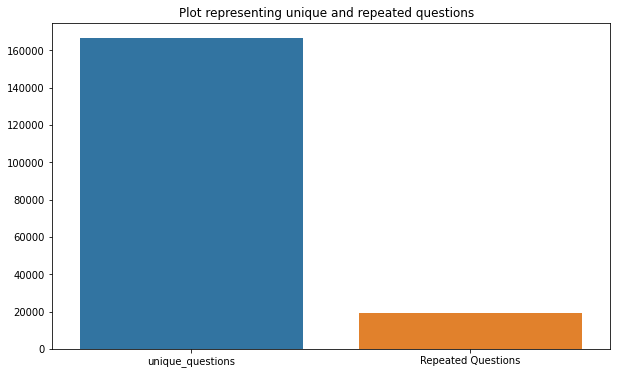

In [ ]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

###3.2.3 Checking for Duplicates </h3>

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


###3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 38



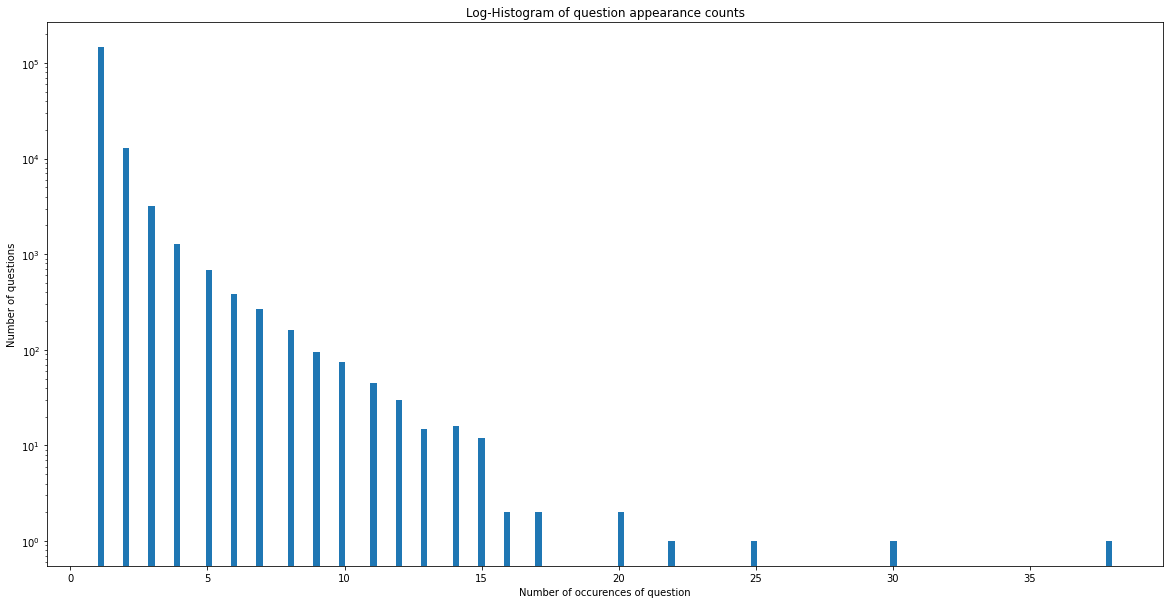

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

###3.2.5 Checking for NULL values </h3>

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1  ...  question2 is_duplicate
105780  105780  174363  ...        NaN            0

[1 rows x 6 columns]


In [ ]:
df = df.dropna()

In [ ]:
df.isnull().any()

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

In [ ]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


##3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
if os.path.isfile(file_path+'df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv(file_path+"df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv(file_path+"df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
202876,202876,305305,305306,Do the Lynda.com app movies have DRM?,Is Lynda.com a good learning resource?,0,1,1,37,38,7,6,1.0,13.0,0.076923,2,0
18754,18754,35508,35509,What should I do after bsc in chemistry honors?,What should I do after Bsc in chemistry?,0,1,2,47,40,9,8,7.0,17.0,0.411765,3,1
398924,398924,532170,532171,"There’s a girl I really like, but I don't know...",Can anyone stay for one hour without blinking ...,0,1,1,104,55,22,10,0.0,28.0,0.000000,2,0
360575,360575,260749,112252,What is the best app to track someone's phone ...,How can I track my friend's phone without them...,1,1,1,90,58,15,11,3.0,25.0,0.120000,2,0
134012,134012,21835,38619,"How can we use the word ""contorted"" in a sente...","How do you use the word ""bravado"" in a sentence?",0,1,1,50,48,10,10,7.0,20.0,0.350000,2,0


In [ ]:
df['id'].shape

(99999,)

###3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 14
Number of Questions with minimum length [question2] : 6


####3.3.1.1 Feature: word_share </h4>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



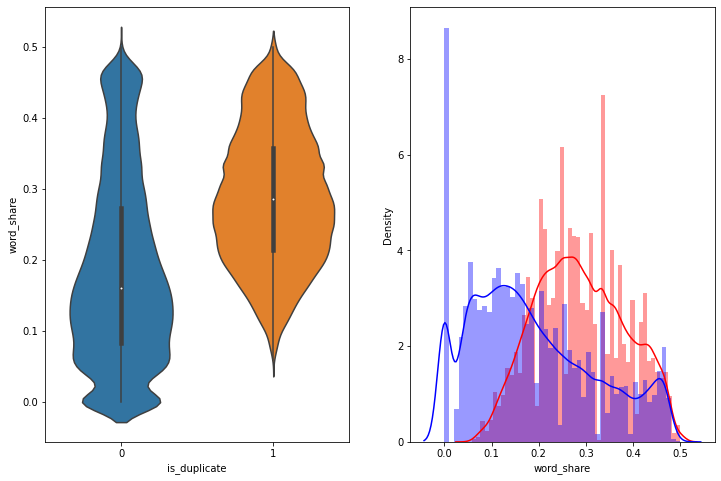

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

####3.3.1.2 Feature: word_Common </h4>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



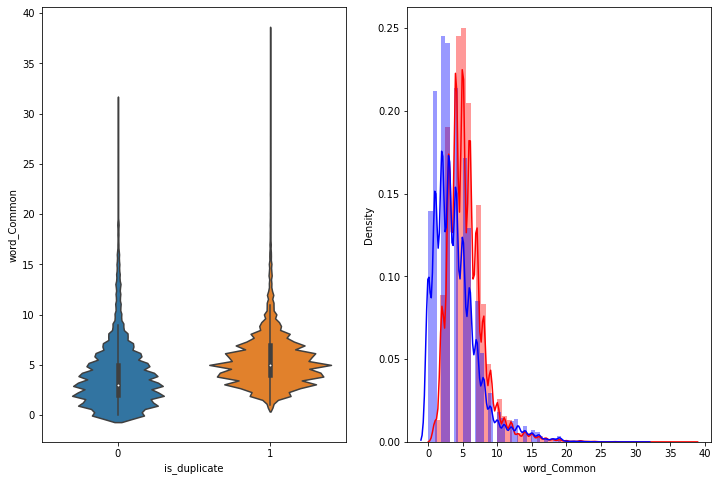

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

#4.EDA: Advanced Feature Extraction.

In [ ]:
pip install fuzzywuzzy

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
202876,202876,305305,305306,Do the Lynda.com app movies have DRM?,Is Lynda.com a good learning resource?,0,1,1,37,38,7,6,1.0,13.0,0.076923,2,0
18754,18754,35508,35509,What should I do after bsc in chemistry honors?,What should I do after Bsc in chemistry?,0,1,2,47,40,9,8,7.0,17.0,0.411765,3,1


In [ ]:
df['id'].shape

(99999,)

##4.1 Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
  x = str(x).lower()
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                          .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                          .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                          .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                          .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                          .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                          .replace("€", " euro ").replace("'ll", " will")
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)


  porter = PorterStemmer()
  pattern = re.compile('\W')

  if type(x) == type(''):
      x = re.sub(pattern, ' ', x)


  if type(x) == type(''):
      x = porter.stem(x)
      example1 = BeautifulSoup(x)
      x = example1.get_text()
                
  return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

##4.2 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2

- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/






- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    # print(token_features)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
# if os.path.isfile(file_path + "nlp_features_train.csv"): # file_path + "nlp_features_train.csv"
#     df = pd.read_csv(file_path + "nlp_features_train.csv",encoding='latin-1')
#     df.fillna('')
# else:
print("Extracting features for train:")
# df = pd.read_csv( file_path + "train.csv")
df = extract_features(df)
df.to_csv(file_path+"nlp_features_train.csv", index=False)


Extracting features for train:
token features...
fuzzy features..


In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [ ]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
202876,202876,305305,305306,do the lynda com app movies have drm,is lynda com a good learning resource,0,1,1,37,38,7,6,1.0,13.0,0.076923,2,0,0.399992,0.399992,0.000000,0.000000,0.285710,0.249997,0.0,0.0,1.0,7.5,52,52,49,51,0.315789
18754,18754,35508,35509,what should i do after bsc in chemistry honors,what should i do after bsc in chemistry,0,1,2,47,40,9,8,7.0,17.0,0.411765,3,1,0.999950,0.666644,0.999983,0.999983,0.999988,0.888879,0.0,1.0,1.0,8.5,100,92,92,100,0.975610


In [ ]:
df['id'].shape

(99999,)

###4.2.1 Analysis of extracted features </h3>

#### 4.2.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt(file_path + 'train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt(file_path + 'train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 73820
Number of data points in class 0 (non duplicate pairs) : 126178


In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname(file_path)

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 3988911
Total number of words in non duplicate pair questions : 8212799


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


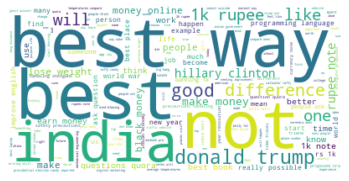

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


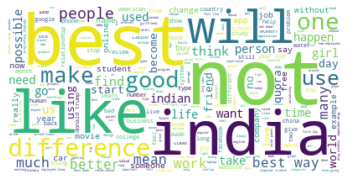

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

####4.2.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

In [ ]:
df.shape[0]

99999

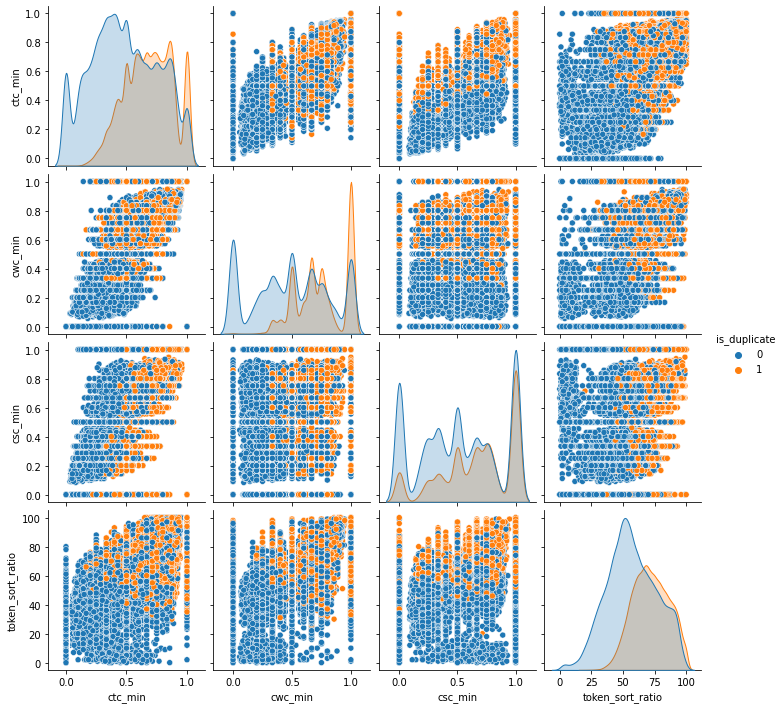

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

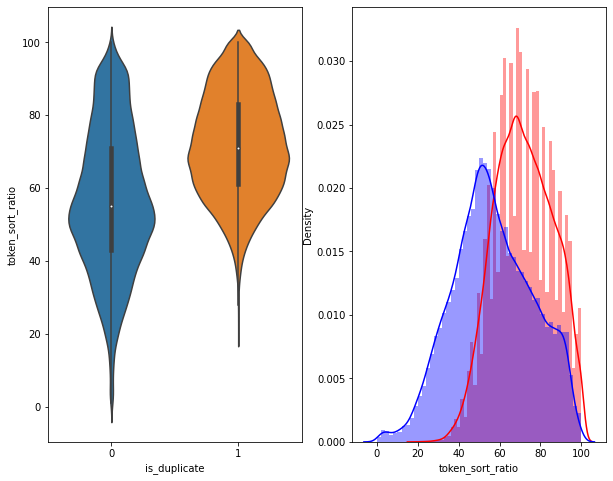

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

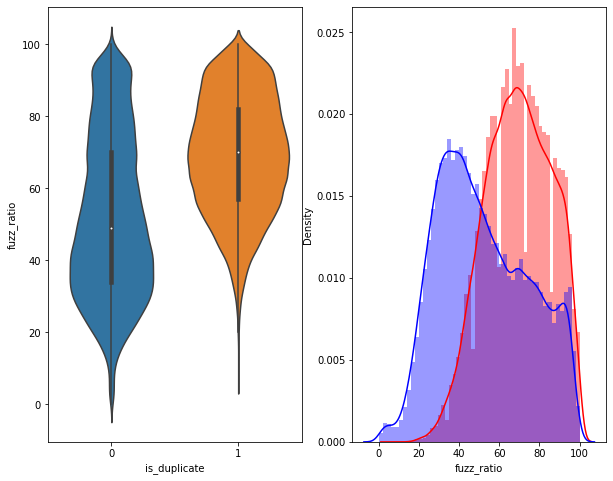

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

##4.3 Visualization

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.141750
[t-SNE] Computed conditional probabilities in 0.311s
[t-SNE] Iteration 50: error = 82.2784882, gradient norm = 0.0545764 (50 iterations in 2.695s)
[t-SNE] Iteration 100: error = 70.8058929, gradient norm = 0.0097709 (50 iterations in 1.953s)
[t-SNE] Iteration 150: error = 69.0166245, gradient norm = 0.0058308 (50 iterations in 1.747s)
[t-SNE] Iteration 200: error = 68.2400818, gradient norm = 0.0037774 (50 iterations in 1.725s)
[t-SNE] Iteration 250: error = 67.7895050, gradient norm = 0.0028166

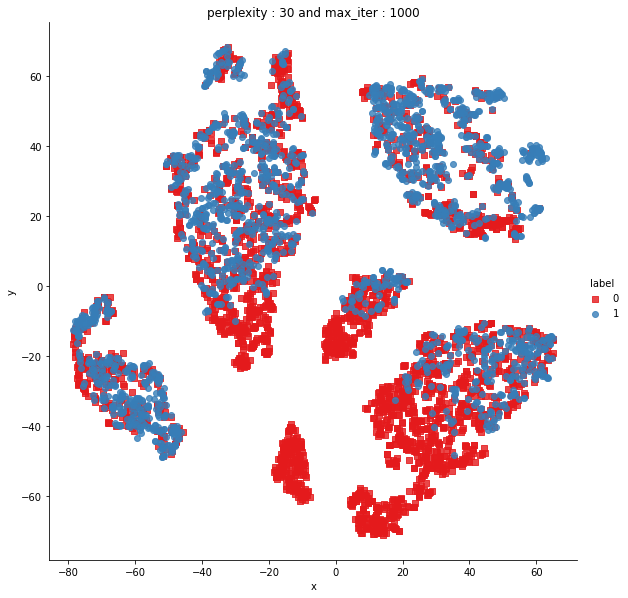

In [ ]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data= df_tsne, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

#5.Data splliting into Train and Test

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [ ]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
202876,202876,305305,305306,do the lynda com app movies have drm,is lynda com a good learning resource,0,1,1,37,38,7,6,1.0,13.0,0.076923,2,0,0.399992,0.399992,0.000000,0.000000,0.285710,0.249997,0.0,0.0,1.0,7.5,52,52,49,51,0.315789
18754,18754,35508,35509,what should i do after bsc in chemistry honors,what should i do after bsc in chemistry,0,1,2,47,40,9,8,7.0,17.0,0.411765,3,1,0.999950,0.666644,0.999983,0.999983,0.999988,0.888879,0.0,1.0,1.0,8.5,100,92,92,100,0.975610


In [ ]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
df['id'].shape

(99999,)

In [ ]:
y = df['is_duplicate']
X = df

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)

In [ ]:
x_tr['id'].size , x_test['id'].size

(69999, 30000)

In [ ]:
print('-'*20+'Training Data'+'-'*20)
print(' similar questions {}'.format(x_tr[x_tr['is_duplicate']==1]['id'].size/x_tr['id'].size))
print(' not similar questions {}'.format(x_tr[x_tr['is_duplicate']==0]['id'].size/x_tr['id'].size))

print('-'*20+'Test Data'+'-'*20)
print(' similar questions are {}'.format(x_test[x_test['is_duplicate']==1]['id'].size/x_test['id'].size))
print(' not similar questions are {}'.format(x_test[x_test['is_duplicate']==0]['id'].size/x_test['id'].size))

--------------------Training Data--------------------
 similar questions 0.3691052729324705
 not similar questions 0.6308947270675296
--------------------Test Data--------------------
 similar questions are 0.3691
 not similar questions are 0.6309


In [ ]:
x_tr.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
173355,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.200000,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.187500
315915,315915,440870,440871,who are some individuals to have given superb ...,what are some of the sledging instances in int...,0,1,1,103,60,17,10,4.0,26.0,0.153846,2,0,0.599988,0.333330,0.499992,0.374995,0.545450,0.333331,0.0,0.0,7.0,14.5,66,52,50,55,0.295082


#6.Featurizing text data with tfidf weighted word-vectors

##6.1 on question_1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
que_tr_1 = list(x_tr['question1']) 
que_test_1 = list(x_test['question1'])

tfidf = TfidfVectorizer(lowercase=False, max_features = 100)
tfidf.fit(que_tr_1)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=100,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
x_tr_que_tfidf_1 = tfidf.transform(que_tr_1)

x_test_que_tfidf_1 = tfidf.transform(que_test_1)

In [ ]:
print("Shape of matrix after one hot encodig ",x_tr_que_tfidf_1.shape)
print("Shape of matrix after one hot encodig ",x_test_que_tfidf_1.shape)

Shape of matrix after one hot encodig  (69999, 100)
Shape of matrix after one hot encodig  (30000, 100)


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
df['id'].shape

(99999,)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm') # en_vectors_web_lg, which includes over 1 million unique vectors.

In [ ]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
vecs1_tr = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(x_tr['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    n = len(doc1)
    if(n!=0):
      m = len(doc1[0].vector)
    else:
      m = 96
    mean_vec1 = np.zeros([n, m])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_tr.append(mean_vec1)


100%|██████████| 69999/69999 [37:55<00:00, 30.77it/s]


In [ ]:
vecs1_tr[0].shape, vecs1_tr[100].shape, len(doc1), len(doc1[0].vector)

((96,), (96,), 10, 96)

In [ ]:
doc1[0].vector

array([ 0.3763715 ,  0.10532662,  1.4533844 , -0.28698087,  3.6503935 ,
        0.97931087,  1.5888419 ,  2.2075431 , -2.050149  ,  4.3217173 ,
       -2.8328185 , -2.79831   , -0.09362406, -3.3989518 ,  0.92466205,
        1.9301122 ,  1.295231  ,  0.01214755, -0.7063968 ,  0.30088243,
       -1.2972752 , -1.5129614 , -1.6312468 , -1.2716315 , -1.1198723 ,
        4.2163177 , -0.15887931, -0.10876264, -0.6944587 ,  2.4156814 ,
       -2.2005112 ,  0.73724544,  1.784922  ,  3.246128  ,  5.910227  ,
        0.36574838,  0.06659666,  0.5309937 ,  1.2235808 , -1.3527976 ,
       -1.8840401 ,  2.28212   ,  1.1649442 ,  0.8529378 , -1.086207  ,
       -3.3912518 ,  1.7874286 , -3.1152291 , -2.319133  , -2.760988  ,
        1.4763534 ,  3.4100714 ,  0.32979494,  7.6178265 , -1.4936702 ,
       -1.3438127 ,  0.08113813,  2.8833957 , -1.9273978 , -3.2157397 ,
       -0.4524957 , -4.0733256 , -1.6178622 ,  1.9137633 , -2.9236608 ,
        1.0245074 ,  2.9203224 , -5.045659  ,  3.6613832 ,  0.68

In [ ]:
type(vecs1_tr)

list

In [ ]:
x_tr['tfidf_w2v_q1'] = list(vecs1_tr)

In [ ]:
x_tr.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1
173355,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.2,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.1875,"[27.608693540096283, 68.19955718517303, 57.713..."


In [ ]:
vecs1_test = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(x_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    n = len(doc1)
    if(n!=0):
      m = len(doc1[0].vector)
    else:
      m = 96
    mean_vec1 = np.zeros([n, m])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_test.append(mean_vec1)

100%|██████████| 30000/30000 [15:20<00:00, 32.58it/s]


In [ ]:
x_test['tfidf_w2v_q1'] = list(vecs1_test)

In [ ]:
vecs1_test[0].shape

(96,)

In [ ]:
x_test.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1
281796,281796,361204,396244,why is india a great country,do you think india is a great country if so ...,1,1,1,29,50,6,11,5.0,17.0,0.294118,2,0,0.999967,0.749981,0.999967,0.428565,0.999983,0.54545,0.0,0.0,5.0,8.5,100,75,62,83,0.566667,"[7.6998284459114075, -4.791664958000183, -8.45..."


##6.2 on question_2

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
que_tr_2 = list(x_tr['question2']) 
que_test_2 = list(x_test['question2'])

tfidf = TfidfVectorizer(lowercase=False,  max_features = 100)
tfidf.fit(que_tr_2)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=100,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
x_tr_que_tfidf_2 = tfidf.transform(que_tr_2)

x_test_que_tfidf_2 = tfidf.transform(que_test_2)

In [ ]:
print("Shape of matrix after one hot encodig ",x_tr_que_tfidf_1.shape)
print("Shape of matrix after one hot encodig ",x_test_que_tfidf_1.shape)

Shape of matrix after one hot encodig  (69999, 100)
Shape of matrix after one hot encodig  (30000, 100)


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
df['id'].shape

(99999,)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm') # en_vectors_web_lg, which includes over 1 million unique vectors.

In [ ]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
vecs2_tr = []
for qu2 in tqdm(list(x_tr['question2'])):
    doc2 = nlp(qu2) 
    n = len(doc2)
    if(n!=0):
      m = len(doc2[0].vector)
    else:
      m = 96
    mean_vec2 = np.zeros([n, m])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2_tr.append(mean_vec2)


100%|██████████| 69999/69999 [36:52<00:00, 31.64it/s]


In [ ]:
x_tr['tfidf_w2v_q2'] = list(vecs2_tr)

In [ ]:
x_tr.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2
173355,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.2,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.1875,"[27.608693540096283, 68.19955718517303, 57.713...","[-7.1943442821502686, -7.962746500968933, 0.91..."


In [ ]:
vecs2_test = []
for qu2 in tqdm(list(x_test['question2'])):
    doc2 = nlp(qu2) 
    n = len(doc2)
    if(n!=0):
      m = len(doc2[0].vector)
    else:
      m = 96
    mean_vec2 = np.zeros([n, m])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2_test.append(mean_vec2)


100%|██████████| 30000/30000 [16:06<00:00, 31.04it/s]


In [ ]:
x_test['tfidf_w2v_q2'] = list(vecs2_test)

In [ ]:
x_test.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2
281796,281796,361204,396244,why is india a great country,do you think india is a great country if so ...,1,1,1,29,50,6,11,5.0,17.0,0.294118,2,0,0.999967,0.749981,0.999967,0.428565,0.999983,0.54545,0.0,0.0,5.0,8.5,100,75,62,83,0.566667,"[7.6998284459114075, -4.791664958000183, -8.45...","[-11.961275041103363, 30.686645030975342, 21.5..."


In [ ]:
x_tr.to_csv(file_path+"x_tr.csv")
x_test.to_csv(file_path+"x_test.csv")

#7.Creating Final Features dataframe

##7.1 TFIDF-W2V

In [ ]:
# #prepro_features_train.csv (Simple Preprocessing Feartures)
# #nlp_features_train.csv (NLP Features)
# if os.path.isfile('nlp_features_train.csv'):
#     dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
# else:
#     print("download nlp_features_train.csv from drive or run previous notebook")

# if os.path.isfile('df_fe_without_preprocessing_train.csv'):
#     dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
# else:
#     print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
x_tr_tfidf_w2v_q1 = pd.DataFrame(x_tr.tfidf_w2v_q1.values.tolist(), index= x_tr.index)
x_tr_tfidf_w2v_q2 = pd.DataFrame(x_tr.tfidf_w2v_q2.values.tolist(), index= x_tr.index)

In [ ]:
x_tr_tfidf_w2v_q1.shape, x_tr_tfidf_w2v_q2.shape

((69999, 96), (69999, 96))

In [ ]:
x_test_tfidf_w2v_q1 = pd.DataFrame(x_test.tfidf_w2v_q1.values.tolist(), index= x_test.index)
x_test_tfidf_w2v_q2 = pd.DataFrame(x_test.tfidf_w2v_q2.values.tolist(), index= x_test.index)

In [ ]:
x_test_tfidf_w2v_q1.shape, x_test_tfidf_w2v_q2.shape

((30000, 96), (30000, 96))

In [ ]:
x_tr_tfidf_w2v_q1['id'] = x_tr['id']
x_tr_tfidf_w2v_q2['id'] = x_tr['id']

In [ ]:
x_test_tfidf_w2v_q1['id'] = x_test['id']
x_test_tfidf_w2v_q2['id'] = x_test['id']

In [ ]:
x_test_tfidf_w2v_q2.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,id
281796,-11.961275,30.686645,21.514403,-41.479065,74.782141,53.854362,19.722804,32.782901,46.166021,62.680717,-28.539975,-0.776401,33.821309,-12.425292,-13.897262,-14.310535,-28.411796,-26.261544,-16.353198,14.284668,-25.947575,7.532142,-37.581713,2.134574,-16.851018,5.308042,22.487617,-8.356027,1.831120,-10.974507,-10.559473,-26.555597,-22.319779,-6.668614,15.678431,17.476919,8.467898,-14.839332,-29.157684,6.572223,...,49.506187,-0.304853,-9.375717,46.752196,11.930234,-20.129397,-33.894379,16.738769,-17.691303,2.523677,6.019789,-10.621918,24.959810,-16.745259,50.471045,25.302816,-17.087469,-20.164252,-30.556275,32.861540,16.917008,-42.373757,9.493308,-44.387236,-25.522498,15.904073,-28.902951,30.714660,11.313164,62.291837,-5.163862,-21.578059,8.935228,-28.432307,-62.849478,-18.696335,8.611474,-16.970136,-9.008602,281796
81005,48.467626,16.473289,-15.573934,12.633487,30.793013,1.397436,12.438805,-0.187270,49.159482,59.709683,39.249963,-11.826972,-27.257053,-25.043691,16.295111,30.780083,-28.398411,-1.860925,-25.015253,-25.293676,24.020865,-4.743004,-2.819678,-0.171103,4.148356,14.538785,0.414370,-11.149069,4.188268,5.937840,-2.786266,12.712134,-24.536151,-1.419984,11.075011,30.363437,8.009015,-10.014414,-29.731288,-31.027184,...,-23.663886,16.954418,-29.176929,50.340644,-31.184983,6.062659,0.841223,-4.312394,-5.407816,27.728574,-36.063729,20.411804,-2.004856,-33.927038,17.036429,-4.983451,8.654602,-15.743562,-27.158860,27.327088,-20.927744,-14.694117,15.451545,38.588978,-28.927176,9.899685,5.481427,21.626741,29.314749,-33.972436,-17.446337,1.754320,37.760758,-30.857436,-21.910231,1.057455,18.910111,27.492588,10.694712,81005


In [ ]:
x_tr.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2
173355,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.200000,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.187500,"[27.608693540096283, 68.19955718517303, 57.713...","[-7.1943442821502686, -7.962746500968933, 0.91..."
315915,315915,440870,440871,who are some individuals to have given superb ...,what are some of the sledging instances in int...,0,1,1,103,60,17,10,4.0,26.0,0.153846,2,0,0.599988,0.333330,0.499992,0.374995,0.545450,0.333331,0.0,0.0,7.0,14.5,66,52,50,55,0.295082,"[-42.91293740272522, 19.62633788585663, 14.827...","[-15.810344696044922, 14.225340127944946, 36.0..."


In [ ]:
x_test.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2
281796,281796,361204,396244,why is india a great country,do you think india is a great country if so ...,1,1,1,29,50,6,11,5.0,17.0,0.294118,2,0,0.999967,0.749981,0.999967,0.428565,0.999983,0.545450,0.0,0.0,5.0,8.5,100,75,62,83,0.566667,"[7.6998284459114075, -4.791664958000183, -8.45...","[-11.961275041103363, 30.686645030975342, 21.5..."
81005,81005,137605,137606,what is life like working on a us navy submari...,what is life like on a us navy lpd,0,1,1,124,35,24,9,6.0,31.0,0.193548,2,0,0.799984,0.333331,0.999975,0.363633,0.888879,0.285713,0.0,1.0,19.0,18.5,94,40,39,77,0.500000,"[6.629557013511658, 27.01751083135605, -2.3637...","[48.46762561798096, 16.473288774490356, -15.57..."


In [ ]:
x_tr.shape, x_test.shape

((69999, 34), (30000, 34))

In [ ]:
if not os.path.isfile(file_path + 'final_features_tfidf_w2v_tr.csv'):

    print(x_tr.shape)
    x_tr  = x_tr.merge(x_tr_tfidf_w2v_q1, on='id',how='left')
    x_tr  = x_tr.merge(x_tr_tfidf_w2v_q2, on='id',how='left')
    print(x_tr.shape)

    print(x_test.shape)
    x_test  = x_test.merge(x_test_tfidf_w2v_q1, on='id',how='left')
    x_test  = x_test.merge(x_test_tfidf_w2v_q2, on='id',how='left')
    print(x_test.shape)


    x_tr.to_csv(file_path + 'final_features_tfidf_w2v_tr.csv')
    x_test.to_csv(file_path + 'final_features_tfidf_w2v_test.csv')

(69999, 34)
(69999, 226)
(30000, 34)
(30000, 226)


In [ ]:
x_tr.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,5_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.200000,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.187500,"[27.608693540096283, 68.19955718517303, 57.713...","[-7.1943442821502686, -7.962746500968933, 0.91...",27.608694,68.199557,57.713228,-42.038758,1.138804,43.005838,...,-8.568714,26.545976,14.181903,7.060493,20.773304,-40.239622,56.590417,-11.711949,28.892556,1.500287,5.361576,-28.807152,26.945491,-0.740627,-5.635177,33.541427,30.313646,13.783543,-3.891814,-38.287071,-1.402800,-27.963342,-19.371894,-2.553702,5.590363,-10.439759,13.447011,-31.258602,29.148300,4.793800,17.462434,-11.160174,-30.726616,16.773767,-72.756871,-26.995647,-37.228156,22.700085,-6.516477,-15.113843
1,315915,440870,440871,who are some individuals to have given superb ...,what are some of the sledging instances in int...,0,1,1,103,60,17,10,4.0,26.0,0.153846,2,0,0.599988,0.333330,0.499992,0.374995,0.545450,0.333331,0.0,0.0,7.0,14.5,66,52,50,55,0.295082,"[-42.91293740272522, 19.62633788585663, 14.827...","[-15.810344696044922, 14.225340127944946, 36.0...",-42.912937,19.626338,14.827212,-69.368962,4.493343,7.414638,...,-7.244350,18.720593,6.816866,0.223558,48.112044,2.077119,16.143087,8.009598,9.413917,7.233769,16.042032,-20.587979,-12.160207,-2.878400,-9.821054,9.845156,26.180203,-1.562467,11.160669,-6.356114,31.029268,-20.528015,-18.941326,-4.067209,-24.720144,5.736472,25.635817,-4.949913,-0.365432,7.440832,16.911699,30.127592,12.788931,9.707571,-56.703979,-23.411005,-17.060780,23.994129,9.035850,-2.050304


In [ ]:
x_test.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,5_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,281796,361204,396244,why is india a great country,do you think india is a great country if so ...,1,1,1,29,50,6,11,5.0,17.0,0.294118,2,0,0.999967,0.749981,0.999967,0.428565,0.999983,0.545450,0.0,0.0,5.0,8.5,100,75,62,83,0.566667,"[7.6998284459114075, -4.791664958000183, -8.45...","[-11.961275041103363, 30.686645030975342, 21.5...",7.699828,-4.791665,-8.456063,7.823763,30.127910,29.341214,...,49.279033,49.506187,-0.304853,-9.375717,46.752196,11.930234,-20.129397,-33.894379,16.738769,-17.691303,2.523677,6.019789,-10.621918,24.959810,-16.745259,50.471045,25.302816,-17.087469,-20.164252,-30.556275,32.861540,16.917008,-42.373757,9.493308,-44.387236,-25.522498,15.904073,-28.902951,30.714660,11.313164,62.291837,-5.163862,-21.578059,8.935228,-28.432307,-62.849478,-18.696335,8.611474,-16.970136,-9.008602
1,81005,137605,137606,what is life like working on a us navy submari...,what is life like on a us navy lpd,0,1,1,124,35,24,9,6.0,31.0,0.193548,2,0,0.799984,0.333331,0.999975,0.363633,0.888879,0.285713,0.0,1.0,19.0,18.5,94,40,39,77,0.500000,"[6.629557013511658, 27.01751083135605, -2.3637...","[48.46762561798096, 16.473288774490356, -15.57...",6.629557,27.017511,-2.363709,-59.672545,63.653287,14.199391,...,50.798472,-23.663886,16.954418,-29.176929,50.340644,-31.184983,6.062659,0.841223,-4.312394,-5.407816,27.728574,-36.063729,20.411804,-2.004856,-33.927038,17.036429,-4.983451,8.654602,-15.743562,-27.158860,27.327088,-20.927744,-14.694117,15.451545,38.588978,-28.927176,9.899685,5.481427,21.626741,29.314749,-33.972436,-17.446337,1.754320,37.760758,-30.857436,-21.910231,1.057455,18.910111,27.492588,10.694712


##7.2 TFIDF

In [ ]:
x_tr.columns.values

array(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',
       'tfidf_w2v_q1', 'tfidf_w2v_q2', '0_x', '1_x', '2_x', '3_x', '4_x',
       '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x',
       '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x',
       '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x',
       '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x',
       '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x',
       '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x',
       '54_x', 

In [ ]:
x_tr = x_tr[['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']]

In [ ]:
x_test = x_test[['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']]

In [ ]:
x_tr.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.200000,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.187500
1,315915,440870,440871,who are some individuals to have given superb ...,what are some of the sledging instances in int...,0,1,1,103,60,17,10,4.0,26.0,0.153846,2,0,0.599988,0.333330,0.499992,0.374995,0.545450,0.333331,0.0,0.0,7.0,14.5,66,52,50,55,0.295082


In [ ]:
x_tr_que_tfidf_1.shape, x_tr_que_tfidf_2.shape, x_test_que_tfidf_1.shape, x_test_que_tfidf_2.shape

((69999, 100), (69999, 100), (30000, 100), (30000, 100))

In [ ]:
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
x_tr_que_tfidf_1 = pd.DataFrame(x_tr_que_tfidf_1.todense())
x_tr_que_tfidf_2 = pd.DataFrame(x_tr_que_tfidf_2.todense())

x_test_que_tfidf_1 = pd.DataFrame(x_test_que_tfidf_1.todense())
x_test_que_tfidf_2 = pd.DataFrame(x_test_que_tfidf_2.todense())

In [ ]:
x_tr_que_tfidf_1.shape, x_tr_que_tfidf_2.shape, x_test_que_tfidf_1.shape, x_test_que_tfidf_2.shape

((69999, 100), (69999, 100), (30000, 100), (30000, 100))

In [ ]:
x_tr_que_tfidf_1['id'] = x_tr['id']
x_tr_que_tfidf_2['id'] = x_tr['id']

In [ ]:
x_test_que_tfidf_1['id'] = x_test['id']
x_test_que_tfidf_2['id'] = x_test['id']

In [ ]:
x_tr_que_tfidf_1.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,id
0,0.0,0.0,0.0,0.349559,0.0,0.407394,0.0,0.00000,0.0,0.00000,0.0,0.0,0.245807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219715,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.176089,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.288196,0.355616,0.000000,0.0,0.383894,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.178356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343307,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173355
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.27145,0.0,0.44794,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.394519,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.396049,0.0,0.000000,0.0,0.0,0.391764,0.0,0.0,0.0,0.0,0.0,0.0,0.251056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.44346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315915


In [ ]:
x_test_que_tfidf_2.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35895,0.0,0.395537,0.0,0.191757,0.0,0.0,...,0.0,0.0,0.0,0.452143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480631,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.303321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.30563,0.0,281796
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.212971,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.563901,0.0,0.0,0.0,0.0,0.0,0.198717,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,81005


In [ ]:
x_tr.shape, x_test.shape

((69999, 32), (30000, 32))

In [ ]:
if not os.path.isfile(file_path + 'final_features_tfidf_tr.csv'):

    print(x_tr.shape)
    x_tr  = x_tr.merge(x_tr_que_tfidf_1, on='id',how='left')
    x_tr  = x_tr.merge(x_tr_que_tfidf_2, on='id',how='left')
    print(x_tr.shape)

    print(x_test.shape)
    x_test  = x_test.merge(x_test_que_tfidf_1, on='id',how='left')
    x_test  = x_test.merge(x_test_que_tfidf_2, on='id',how='left')
    print(x_test.shape)


    x_tr.to_csv(file_path + 'final_features_tfidf_tr.csv')
    x_test.to_csv(file_path + 'final_features_tfidf_test.csv')

(69999, 32)
(69999, 232)
(30000, 32)
(30000, 232)


In [ ]:
x_tr.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,173355,1745,267452,i wish to start investing in equity and mutual...,where should i invest 100k in vanguard funds ...,0,1,1,144,79,27,17,8.0,40.0,0.200000,2,0,0.249997,0.142856,0.874989,0.699993,0.529409,0.333332,0.0,0.0,10.0,22.0,67,54,36,44,0.187500,0.0,0.0,0.0,0.349559,0.0,0.407394,0.0,0.00000,...,0.0,0.0,0.0,0.396077,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.243114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.476907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,315915,440870,440871,who are some individuals to have given superb ...,what are some of the sledging instances in int...,0,1,1,103,60,17,10,4.0,26.0,0.153846,2,0,0.599988,0.333330,0.499992,0.374995,0.545450,0.333331,0.0,0.0,7.0,14.5,66,52,50,55,0.295082,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.27145,...,0.0,0.0,0.0,0.000000,0.0,0.593128,0.0,0.0,0.0,0.0,0.295384,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291887,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_tr.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
x_test.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,281796,361204,396244,why is india a great country,do you think india is a great country if so ...,1,1,1,29,50,6,11,5.0,17.0,0.294118,2,0,0.999967,0.749981,0.999967,0.428565,0.999983,0.545450,0.0,0.0,5.0,8.5,100,75,62,83,0.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.452143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480631,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.303321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.30563,0.0
1,81005,137605,137606,what is life like working on a us navy submari...,what is life like on a us navy lpd,0,1,1,124,35,24,9,6.0,31.0,0.193548,2,0,0.799984,0.333331,0.999975,0.363633,0.888879,0.285713,0.0,1.0,19.0,18.5,94,40,39,77,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.563901,0.0,0.0,0.0,0.0,0.0,0.198717,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


#8.Saving to DB and Loading from DB: Reading data from file and storing into sql table

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

## 8.1 TFIDF - W2V

###8.1.1 Train data

In [ ]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    print(tables)
    return(len(tables))

In [ ]:
#Creating db file from csv
import sqlalchemy
if not os.path.isfile(file_path + 'tfidf_w2v_tr.db'):
  print("not present in drive")
  disk_engine = sqlalchemy.create_engine('sqlite:///'+file_path+'tfidf_w2v_tr.db')
  start = dt.datetime.now()
  chunksize = 180000
  j = 0
  index_start = 1
  for df in pd.read_csv(file_path+'final_features_tfidf_w2v_tr.csv', 
                        names=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
                              'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
                              'q2_n_words', 'word_Common', 'word_Total', 'word_share',
                              'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
                              'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
                              'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
                              'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',
                              'tfidf_w2v_q1', 'tfidf_w2v_q2', '0_x', '1_x', '2_x', '3_x', '4_x',
                              '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x',
                              '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x',
                              '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x',
                              '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x',
                              '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x',
                              '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x',
                              '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x',
                              '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x',
                              '70_x', '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x',
                              '78_x', '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x',
                              '86_x', '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x',
                              '94_x', '95_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
                              '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y',
                              '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y',
                              '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y',
                              '31_y', '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y',
                              '39_y', '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y',
                              '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y',
                              '55_y', '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y',
                              '63_y', '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y',
                              '71_y', '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y',
                              '79_y', '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y',
                              '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
                              '95_y'], 
                        chunksize=chunksize, iterator=True, encoding='utf-8', ):
      df.index += index_start
      j+=1
      print('{} rows'.format(j*chunksize))
      df.to_sql('data', disk_engine, if_exists='append')
      index_start = df.index[-1] + 1

not present in drive
180000 rows


In [ ]:
read_db = file_path + 'tfidf_w2v_tr.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data
[('data',)]


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        data =pd.read_sql_query("""SELECT * From data ORDER BY RANDOM() LIMIT 100001;""", conn_r)
        
        # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
data.shape

(70000, 227)

In [ ]:
data[data['is_duplicate']=='is_duplicate']

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
50732,NaN,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y


In [ ]:
data = data.drop(data.index[data['is_duplicate']=='is_duplicate'])

In [ ]:
data.head(2)

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,41387.0,294555,47599,6306,who would be a better president hillary clint...,who is the better candidate for being the pres...,1,5,3,65,117,11,20,7.0,28.0,0.25,8,2,0.857130612419823,0.599994000059999,0.499987500312492,0.285710204139941,0.727266115762584,0.39999800001,1.0,1.0,9.0,15.5,90,64,62,69,0.515151515151515,[ -4.64983994 5.06869847 -3.11539841 -37.97...,[ -17.43441989 -4.05206048 53.43405056 -...,-4.64983993768692,5.06869846582413,-3.11539840698242,-37.9745254516602,-9.45093715190888,...,-25.0291868448257,38.6667686700821,47.6835848093033,-41.8758891522884,9.89321112632752,-21.2375934123993,68.7279915064573,36.6591718494892,5.11638236045837,45.4468436837196,-14.8962029218674,-44.8534897267819,32.6431856751442,24.4516477584839,-14.0429061055183,9.9424319267273,-1.70706245303154,-40.7929311990738,-30.5186699926853,-16.1984111368656,15.1391609720886,-46.0956941246986,-57.9398511499166,-44.4741082191467,-12.29988104105,-20.3651510775089,58.5968614816666,8.37535321712494,30.0866848230362,46.7211168408394,17.6403857469559,37.4319207668305,-4.79677444696426,29.9887899160385,-100.386833667755,24.844566822052,4.86792778968811,56.9776278734207,14.8915197253227,8.29184913635254
1,15998.0,345359,473644,473645,how can i open a skill development institute i...,which time institute is best in india,0,1,1,113,38,21,7,3.0,25.0,0.12,2,0,0.499987500312492,0.285710204139941,0.33332222259258,0.090908264470323,0.428565306209911,0.142856462588273,1.0,0.0,14.0,14.0,65,42,40,61,0.307692307692308,[-11.53804553 -1.31798834 13.83928645 -21.30...,[ 1.65295923 -13.6846914 4.1457696 -13.75...,-11.5380455255508,-1.31798833608627,13.8392864465714,-21.3045844137669,54.2410039901733,...,-10.0311181545258,24.7920528650284,-6.73002053052187,13.249913983047,-3.87367391586304,-19.2578691840172,42.131804138422,-16.327799230814,13.5392346382141,26.2507132291794,8.92784136533737,-54.0819430351257,-25.0121120214462,-9.37299942970276,-8.01537865400314,-7.68162297457457,-13.9821706414223,19.5471611395478,-4.41443753242493,10.414143294096,14.7437282800674,-22.217215180397,-2.01735758781433,-5.68383526802063,15.3202514648437,-45.8313265442848,4.92065358161926,-4.46891224384308,48.1924984455109,73.8799775093794,8.23593951761723,-10.8548973202705,-12.2186459302902,9.13414919376373,-25.0729923248291,-9.32069027423859,13.8793580532074,36.4834846556187,16.5123729705811,27.9061470031738


In [ ]:
data[pd.isnull(data).any(axis=1)]

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
12888,34943.0,190570,289688,289689,None,time is money can some one explain how it works,0,1,1,1,49,1,9,0.0,10.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,[nan nan nan nan nan nan nan nan nan nan nan n...,[ 1.47261497e+01 2.17834438e+01 -2.15602746e+...,None,None,None,None,None,...,70.9388235807419,-31.8560846745968,-27.6980261802673,-18.4916008710861,32.9337363243103,-33.358056306839,10.8744260072708,25.3061537444591,3.09661918878555,-5.44866269826889,35.2615778446198,-34.7905353605747,-51.0820861458778,27.5910440683365,-12.986646361649,22.7357919216156,15.5795795917511,36.3141270130873,-28.8081525964662,6.7568781375885,36.119308874011,-13.9986906051636,-21.3520339727402,-12.9810325056314,-12.9330896139145,-32.8339539766312,-44.3447976112366,36.2757480144501,31.5648869276047,18.5498933196068,-5.30768263339996,-16.027182996273,-22.1446913182735,-5.96816575527191,-39.0013278722763,-33.7741242647171,-23.3500831127167,33.112549841404,61.5479754209518,17.4400582313538
42525,50243.0,208485,312495,312496,None,given that pacer makes money from usage why d...,0,1,1,1,101,1,16,0.0,17.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,[nan nan nan nan nan nan nan nan nan nan nan n...,[ 0.89003944 -2.07916043 48.44507176 -14.40...,None,None,None,None,None,...,45.1678450703621,1.83327800035477,-20.4093137234449,-13.8296381235123,17.0806336402893,-5.33193922042847,11.3420872502029,0.194530248641968,12.2892830371857,-28.713550567627,26.7522855997086,-23.6024951189756,-16.9341928362846,6.59550213813782,-5.33280044794083,38.9882388114929,16.1946227550507,-1.33130061626434,-38.0911577343941,4.55537223815918,32.4624630957842,-36.1290276944637,-24.7319486141205,-8.42173803597689,-11.3959999084473,-25.6717410087585,-7.73246943950653,17.2720429301262,13.5728070437908,-12.1850044727325,-16.4092950820923,4.35381837189197,2.17938327789307,20.2110241651535,-35.896678686142,-36.5328974723816,-1.6734983921051,22.7906621396542,18.1247460842133,2.56290471553802
44202,5290.0,134403,214814,214815,None,what is your take on the undercover report tha...,0,1,1,1,144,1,25,0.0,24.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,[nan nan nan nan nan nan nan nan nan nan nan n...,[-30.68893778 -2.43411691 17.69741669 -26.23...,None,None,None,None,None,...,34.6410902738571,10.3291846960783,6.05114477872849,-41.7165780961514,10.8152848018799,11.0055705904961,50.5157607793808,46.9680024981499,-11.4789357185364,36.2982343435288,40.9439063072205,-54.7809942364693,-30.9762117862701,1.66788268089294,-8.62983518838882,-3.61961305141449,21.0077638030052,-2.65220552682877,-29.3591721057892,-66.3611451387405,23.3239617664367,-21.6291620135307,-0.786677360534668,9.20647343993187,-4.1320743560791,10.4536202084273,1.92360619455576,-7.98336936533451,27.9149115532637,-8.26417850703001,21.3681231886148,-3.20647466182709,22.4192373752594,46.8083694577217,-38.4584658741951,-2.00279399752617,-5.08598220348358,13.4152525067329,-2.46856021881104,28.391014456749


In [ ]:
# remove the first row 
# data.drop(data.index[0], inplace=True)
y_train = data['is_duplicate'].values
data.drop(['id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.shape, y_train.shape

((69999, 224), (69999,))

In [ ]:
data.head(2)

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,47599,6306,who would be a better president hillary clint...,who is the better candidate for being the pres...,5,3,65,117,11,20,7.0,28.0,0.25,8,2,0.857130612419823,0.599994000059999,0.499987500312492,0.285710204139941,0.727266115762584,0.39999800001,1.0,1.0,9.0,15.5,90,64,62,69,0.515151515151515,[ -4.64983994 5.06869847 -3.11539841 -37.97...,[ -17.43441989 -4.05206048 53.43405056 -...,-4.64983993768692,5.06869846582413,-3.11539840698242,-37.9745254516602,-9.45093715190888,27.792270898819,20.489373922348,-9.89277696609497,...,-25.0291868448257,38.6667686700821,47.6835848093033,-41.8758891522884,9.89321112632752,-21.2375934123993,68.7279915064573,36.6591718494892,5.11638236045837,45.4468436837196,-14.8962029218674,-44.8534897267819,32.6431856751442,24.4516477584839,-14.0429061055183,9.9424319267273,-1.70706245303154,-40.7929311990738,-30.5186699926853,-16.1984111368656,15.1391609720886,-46.0956941246986,-57.9398511499166,-44.4741082191467,-12.29988104105,-20.3651510775089,58.5968614816666,8.37535321712494,30.0866848230362,46.7211168408394,17.6403857469559,37.4319207668305,-4.79677444696426,29.9887899160385,-100.386833667755,24.844566822052,4.86792778968811,56.9776278734207,14.8915197253227,8.29184913635254
1,473644,473645,how can i open a skill development institute i...,which time institute is best in india,1,1,113,38,21,7,3.0,25.0,0.12,2,0,0.499987500312492,0.285710204139941,0.33332222259258,0.090908264470323,0.428565306209911,0.142856462588273,1.0,0.0,14.0,14.0,65,42,40,61,0.307692307692308,[-11.53804553 -1.31798834 13.83928645 -21.30...,[ 1.65295923 -13.6846914 4.1457696 -13.75...,-11.5380455255508,-1.31798833608627,13.8392864465714,-21.3045844137669,54.2410039901733,8.23040080070496,46.8001040816307,-19.6304092109203,...,-10.0311181545258,24.7920528650284,-6.73002053052187,13.249913983047,-3.87367391586304,-19.2578691840172,42.131804138422,-16.327799230814,13.5392346382141,26.2507132291794,8.92784136533737,-54.0819430351257,-25.0121120214462,-9.37299942970276,-8.01537865400314,-7.68162297457457,-13.9821706414223,19.5471611395478,-4.41443753242493,10.414143294096,14.7437282800674,-22.217215180397,-2.01735758781433,-5.68383526802063,15.3202514648437,-45.8313265442848,4.92065358161926,-4.46891224384308,48.1924984455109,73.8799775093794,8.23593951761723,-10.8548973202705,-12.2186459302902,9.13414919376373,-25.0729923248291,-9.32069027423859,13.8793580532074,36.4834846556187,16.5123729705811,27.9061470031738


In [ ]:
data.columns.values

array(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'tfidf_w2v_q1',
       'tfidf_w2v_q2', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x',
       '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x',
       '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x',
       '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x',
       '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x',
       '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x',
       '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x',
       '55_x', '56_x', '57_x'

In [ ]:
train_data_tfidf_w2v_tr = data[[  'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio',
        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x',
       '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x',
       '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x',
       '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x',
       '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x',
       '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x',
       '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x',
       '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x', '62_x',
       '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x',
       '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x', '78_x',
       '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x', '86_x',
       '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x', '94_x',
       '95_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y',
       '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y',
       '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y', '23_y',
       '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y',
       '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y',
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y',
       '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y',
       '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y', '63_y',
       '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y', '71_y',
       '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y', '79_y',
       '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y', '87_y',
       '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y', '95_y']]

In [ ]:
train_data_tfidf_w2v_tr.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,5,3,65,117,11,20,7.0,28.0,0.25,8,2,0.857130612419823,0.599994000059999,0.499987500312492,0.285710204139941,0.727266115762584,0.39999800001,1.0,1.0,9.0,15.5,90,64,62,69,0.515151515151515,-4.64983993768692,5.06869846582413,-3.11539840698242,-37.9745254516602,-9.45093715190888,27.792270898819,20.489373922348,-9.89277696609497,22.5724723339081,30.1795962452889,-2.84929227828979,1.2104377746582,-33.9376243054867,-60.9222337007523,...,-25.0291868448257,38.6667686700821,47.6835848093033,-41.8758891522884,9.89321112632752,-21.2375934123993,68.7279915064573,36.6591718494892,5.11638236045837,45.4468436837196,-14.8962029218674,-44.8534897267819,32.6431856751442,24.4516477584839,-14.0429061055183,9.9424319267273,-1.70706245303154,-40.7929311990738,-30.5186699926853,-16.1984111368656,15.1391609720886,-46.0956941246986,-57.9398511499166,-44.4741082191467,-12.29988104105,-20.3651510775089,58.5968614816666,8.37535321712494,30.0866848230362,46.7211168408394,17.6403857469559,37.4319207668305,-4.79677444696426,29.9887899160385,-100.386833667755,24.844566822052,4.86792778968811,56.9776278734207,14.8915197253227,8.29184913635254
1,1,1,113,38,21,7,3.0,25.0,0.12,2,0,0.499987500312492,0.285710204139941,0.33332222259258,0.090908264470323,0.428565306209911,0.142856462588273,1.0,0.0,14.0,14.0,65,42,40,61,0.307692307692308,-11.5380455255508,-1.31798833608627,13.8392864465714,-21.3045844137669,54.2410039901733,8.23040080070496,46.8001040816307,-19.6304092109203,66.5422037243843,36.3367228507996,19.1830409169197,-25.1577630490065,-64.2376973628998,22.2365908622742,...,-10.0311181545258,24.7920528650284,-6.73002053052187,13.249913983047,-3.87367391586304,-19.2578691840172,42.131804138422,-16.327799230814,13.5392346382141,26.2507132291794,8.92784136533737,-54.0819430351257,-25.0121120214462,-9.37299942970276,-8.01537865400314,-7.68162297457457,-13.9821706414223,19.5471611395478,-4.41443753242493,10.414143294096,14.7437282800674,-22.217215180397,-2.01735758781433,-5.68383526802063,15.3202514648437,-45.8313265442848,4.92065358161926,-4.46891224384308,48.1924984455109,73.8799775093794,8.23593951761723,-10.8548973202705,-12.2186459302902,9.13414919376373,-25.0729923248291,-9.32069027423859,13.8793580532074,36.4834846556187,16.5123729705811,27.9061470031738


In [ ]:
train_data_tfidf_w2v_tr.shape, y_train.shape

((69999, 218), (69999,))

### 8.1.2 Test data

In [ ]:
#Creating db file from csv
import sqlalchemy
if not os.path.isfile(file_path + 'tfidf_w2v_test.db'):
  print("not present in drive")
  disk_engine = sqlalchemy.create_engine('sqlite:///'+file_path+'tfidf_w2v_test.db')
  start = dt.datetime.now()
  chunksize = 180000
  j = 0
  index_start = 1
  for df in pd.read_csv(file_path+'final_features_tfidf_w2v_test.csv', 
                        names=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
                              'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
                              'q2_n_words', 'word_Common', 'word_Total', 'word_share',
                              'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
                              'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
                              'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
                              'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',
                              'tfidf_w2v_q1', 'tfidf_w2v_q2', '0_x', '1_x', '2_x', '3_x', '4_x',
                              '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x',
                              '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x',
                              '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x',
                              '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x',
                              '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x',
                              '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x',
                              '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x',
                              '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x',
                              '70_x', '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x',
                              '78_x', '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x',
                              '86_x', '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x',
                              '94_x', '95_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
                              '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y',
                              '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y',
                              '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y',
                              '31_y', '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y',
                              '39_y', '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y',
                              '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y',
                              '55_y', '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y',
                              '63_y', '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y',
                              '71_y', '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y',
                              '79_y', '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y',
                              '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
                              '95_y'], 
                        chunksize=chunksize, iterator=True, encoding='utf-8', ):
      df.index += index_start
      j+=1
      print('{} rows'.format(j*chunksize))
      df.to_sql('data', disk_engine, if_exists='append')
      index_start = df.index[-1] + 1

not present in drive
180000 rows


In [ ]:
read_db = file_path + 'tfidf_w2v_test.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data
[('data',)]


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        data =pd.read_sql_query("""SELECT * From data ORDER BY RANDOM() LIMIT 100001;""", conn_r)
        
        # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
data.shape

(30001, 227)

In [ ]:
data[data['is_duplicate']=='is_duplicate']

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
23308,NaN,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y


In [ ]:
data = data.drop(data.index[data['is_duplicate']=='is_duplicate'])

In [ ]:
data.shape

(30000, 227)

In [ ]:
# remove the first row 
# data.drop(data.index[0], inplace=True)
y_test = data['is_duplicate'].values
data.drop(['id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.shape, y_test.shape

((30000, 224), (30000,))

In [ ]:
data.head(2)

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tfidf_w2v_q1,tfidf_w2v_q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,5514,146,how can i speak english more fluently,how can i learn to speak english fluently,7,9,38,42,7,8,6.0,15.0,0.4,16,2,0.999966667777741,0.749981250468738,0.749981250468738,0.749981250468738,0.857130612419823,0.749990625117186,1.0,1.0,1.0,7.5,93,87,82,79,0.384615384615385,[ -8.02146584 -5.52405596 -36.98517752 7.68...,[-1.12988985e+00 6.27120095e+00 -2.31688151e+...,-8.02146583795547,-5.52405595779419,-36.9851775169373,7.68583071231842,-0.700401782989502,6.9779257774353,5.50678277015686,-1.51084160804749,...,15.6329016685486,-22.4249801635742,7.07560849189758,-3.39871788024902,25.7027799263596,-47.5300951004028,11.7945919036865,1.21510551124811,-24.2762479782104,-11.649277806282,-0.293246150016785,15.243677675724,6.37558329105377,-3.8158446252346,-19.150779902935,38.1677317619324,7.34631943702698,3.83960872888565,5.27332699298859,-27.5989580154419,2.1064395904541,-12.4047727584839,-13.0666589736938,13.1429818868637,14.5123610496521,2.30996055714786,-19.2545718550682,20.342289686203,-3.26866716146469,-6.47484612464905,-14.6215887069702,-6.5528320223093,-3.69395184516907,12.9180691242218,-9.19335007667542,9.01225471496582,-23.3363871574402,5.54211664199829,-29.6178760528564,17.1825745105743
1,33271,27500,what were the major effects of the cambodia ea...,what were the major effects of the cambodia ea...,2,5,121,126,21,21,16.0,36.0,0.444444444444444,7,3,0.714275510349852,0.714275510349852,0.999990000099999,0.999990000099999,0.714282312941367,0.714282312941367,0.0,1.0,0.0,21.0,94,91,95,94,0.786885245901639,[ -8.95103335 19.65979218 42.07945091 -31.15...,[ -5.62203002 17.28253478 40.88960582 -29.33...,-8.95103335380554,19.6597921848297,42.079450905323,-31.1530289649963,47.4479124546051,-14.3505325317383,-4.13371482491493,9.55172138102352,...,4.99068900942802,44.1608332395554,36.7915093898773,-27.2790119051933,32.8445092849433,-21.3734006881714,29.1589372158051,14.4571687579155,-3.04185725748539,4.05300933122635,5.9884033203125,-26.0695634484291,25.6798284053802,8.53255873918533,2.18538917601109,28.3280445337296,7.92431044578552,-8.89316606521606,-14.5809708833694,4.22113326191902,10.0047082602978,-41.1436475515366,-47.4567403793335,-19.9917847327888,-21.4863052368164,-7.77381022833288,38.3537708520889,0.16625714302063,13.9506402900442,-31.9049507975578,25.0410197973251,31.3851109147072,20.1510617733002,5.13298398256302,-47.1625286340714,-11.0631755925715,-16.1483527421951,24.8445405066013,-4.59677809476852,-5.77600445598364


In [ ]:
data.columns.values

array(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'tfidf_w2v_q1',
       'tfidf_w2v_q2', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x',
       '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x',
       '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x',
       '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x',
       '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x',
       '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x',
       '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x',
       '55_x', '56_x', '57_x'

In [ ]:
test_data_tfidf_w2v_test = data[[  'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio',
        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x',
       '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x',
       '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x',
       '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x',
       '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x',
       '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x',
       '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x',
       '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x', '62_x',
       '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x',
       '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x', '78_x',
       '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x', '86_x',
       '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x', '94_x',
       '95_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y',
       '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y',
       '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y', '23_y',
       '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y',
       '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y',
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y',
       '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y',
       '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y', '63_y',
       '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y', '71_y',
       '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y', '79_y',
       '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y', '87_y',
       '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y', '95_y']]

In [ ]:
test_data_tfidf_w2v_test.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,7,9,38,42,7,8,6.0,15.0,0.4,16,2,0.999966667777741,0.749981250468738,0.749981250468738,0.749981250468738,0.857130612419823,0.749990625117186,1.0,1.0,1.0,7.5,93,87,82,79,0.384615384615385,-8.02146583795547,-5.52405595779419,-36.9851775169373,7.68583071231842,-0.700401782989502,6.9779257774353,5.50678277015686,-1.51084160804749,8.29907071590424,22.0053787231445,36.0573937892914,-9.51313614845276,47.2674555778503,-12.6805286407471,...,15.6329016685486,-22.4249801635742,7.07560849189758,-3.39871788024902,25.7027799263596,-47.5300951004028,11.7945919036865,1.21510551124811,-24.2762479782104,-11.649277806282,-0.293246150016785,15.243677675724,6.37558329105377,-3.8158446252346,-19.150779902935,38.1677317619324,7.34631943702698,3.83960872888565,5.27332699298859,-27.5989580154419,2.1064395904541,-12.4047727584839,-13.0666589736938,13.1429818868637,14.5123610496521,2.30996055714786,-19.2545718550682,20.342289686203,-3.26866716146469,-6.47484612464905,-14.6215887069702,-6.5528320223093,-3.69395184516907,12.9180691242218,-9.19335007667542,9.01225471496582,-23.3363871574402,5.54211664199829,-29.6178760528564,17.1825745105743
1,2,5,121,126,21,21,16.0,36.0,0.444444444444444,7,3,0.714275510349852,0.714275510349852,0.999990000099999,0.999990000099999,0.714282312941367,0.714282312941367,0.0,1.0,0.0,21.0,94,91,95,94,0.786885245901639,-8.95103335380554,19.6597921848297,42.079450905323,-31.1530289649963,47.4479124546051,-14.3505325317383,-4.13371482491493,9.55172138102352,30.4646055102348,49.1404094099998,-20.0080252587795,21.8893128633499,-41.3028829097748,16.8939364254475,...,4.99068900942802,44.1608332395554,36.7915093898773,-27.2790119051933,32.8445092849433,-21.3734006881714,29.1589372158051,14.4571687579155,-3.04185725748539,4.05300933122635,5.9884033203125,-26.0695634484291,25.6798284053802,8.53255873918533,2.18538917601109,28.3280445337296,7.92431044578552,-8.89316606521606,-14.5809708833694,4.22113326191902,10.0047082602978,-41.1436475515366,-47.4567403793335,-19.9917847327888,-21.4863052368164,-7.77381022833288,38.3537708520889,0.16625714302063,13.9506402900442,-31.9049507975578,25.0410197973251,31.3851109147072,20.1510617733002,5.13298398256302,-47.1625286340714,-11.0631755925715,-16.1483527421951,24.8445405066013,-4.59677809476852,-5.77600445598364


In [ ]:
test_data_tfidf_w2v_test.shape, y_test.shape

((30000, 218), (30000,))

###8.1.3 Converting String to Numerics

In [ ]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
# https://stackoverflow.com/questions/40790031/pandas-to-numeric-find-out-which-string-it-was-unable-to-parse
cols = list(train_data_tfidf_w2v_tr.columns)
for i in cols:
    train_data_tfidf_w2v_tr[i] = train_data_tfidf_w2v_tr[i].apply(pd.to_numeric, errors='coerce')
    print(i)

freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [ ]:
y_train[:10]

array(['1', '0', '0', '0', '1', '1', '0', '0', '0', '0'], dtype=object)

In [ ]:
y_train = pd.Series(map(int,list(y_train)))

In [ ]:
cols = list(test_data_tfidf_w2v_test.columns)
for i in cols:
    test_data_tfidf_w2v_test[i] = test_data_tfidf_w2v_test[i].apply(pd.to_numeric , errors='coerce')
    print(i)

freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [ ]:
y_test[1:10]

array(['1', '0', '0', '0', '0', '0', '0', '0', '1'], dtype=object)

In [ ]:
y_test = pd.Series(map(int,list(y_test)))

In [ ]:
x_tr_set1 = train_data_tfidf_w2v_tr
x_test_set1 = test_data_tfidf_w2v_test
y_tr_set1 = y_train
y_test_set1 = y_test

In [ ]:
x_tr_set1.shape, x_test_set1.shape, y_tr_set1.shape, y_test_set1.shape

((69999, 218), (30000, 218), (69999,), (30000,))

## 8.2 TFIDF

###8.2.1 Train data

In [ ]:
#Creating db file from csv
import sqlalchemy
if not os.path.isfile(file_path + 'tfidf_tr.db'):
  print("not present in drive")
  disk_engine = sqlalchemy.create_engine('sqlite:///'+file_path+'tfidf_tr.db')
  start = dt.datetime.now()
  chunksize = 180000
  j = 0
  index_start = 1
  for df in pd.read_csv(file_path+'final_features_tfidf_tr.csv', 
                        names=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
                              'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
                              'q2_n_words', 'word_Common', 'word_Total', 'word_share',
                              'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
                              'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
                              'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
                              'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',
                              '0_x', '1_x', '2_x', '3_x', '4_x',
                              '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x',
                              '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x',
                              '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x',
                              '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x',
                              '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x',
                              '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x',
                              '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x',
                              '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x',
                              '70_x', '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x',
                              '78_x', '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x',
                              '86_x', '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x',
                              '94_x', '95_x', '96_x', '97_x', '98_x', '99_x', 
                               '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
                              '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y',
                              '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y',
                              '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y',
                              '31_y', '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y',
                              '39_y', '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y',
                              '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y',
                              '55_y', '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y',
                              '63_y', '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y',
                              '71_y', '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y',
                              '79_y', '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y',
                              '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
                              '95_y', '96_y', '97_y', '98_y', '99_y'], 
                        chunksize=chunksize, iterator=True, encoding='utf-8', ):
      df.index += index_start
      j+=1
      print('{} rows'.format(j*chunksize))
      df.to_sql('data', disk_engine, if_exists='append')
      index_start = df.index[-1] + 1

not present in drive
180000 rows


In [ ]:
read_db = file_path + 'tfidf_tr.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data
[('data',)]


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        data =pd.read_sql_query("""SELECT * From data ORDER BY RANDOM() LIMIT 100001;""", conn_r)
        
        # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
data.shape

(70000, 233)

In [ ]:
data[data['is_duplicate']=='is_duplicate']

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
33459,NaN,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y


In [ ]:
data.head(2)

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,36120.0,18739,8469,16340,what is the sahara and how do the average tem...,what is the sahara and how do the average tem...,1,4,3,104,108,19,20,15.0,33.0,0.454545454545454,7,1,0.857130612419823,0.749990625117186,0.999988889012344,0.999988889012344,0.789469529107742,0.74999625001875,1.0,1.0,1.0,19.5,95,90,93,91,0.847619047619048,0.0,0.0,0.0,0.0,0.0,0.258653200130478,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.708851160176402,0.0,0.408332427776268,0.0,0.0,0.0,0.0,0.221601480778556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175114785140462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50769.0,204303,307159,307160,what are great questions to interview a salesman,what are some great example answers you have g...,0,1,1,49,94,8,15,5.0,23.0,0.217391304347826,2,0,0.499987500312492,0.249996875039062,0.749981250468738,0.374995312558593,0.624992187597655,0.312498046887207,0.0,1.0,8.0,12.0,70,53,46,47,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.44669835411124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219826730416436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375502721911467,0.0


In [ ]:
data = data.drop(data.index[data['is_duplicate']=='is_duplicate'])

In [ ]:
data.shape

(69999, 233)

In [ ]:
# remove the first row 
# data.drop(data.index[0], inplace=True)
y_train = data['is_duplicate'].values
data.drop(['id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.shape, y_train.shape

((69999, 230), (69999,))

In [ ]:
data.head(2)

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,8469,16340,what is the sahara and how do the average tem...,what is the sahara and how do the average tem...,4,3,104,108,19,20,15.0,33.0,0.454545454545454,7,1,0.857130612419823,0.749990625117186,0.999988889012344,0.999988889012344,0.789469529107742,0.74999625001875,1.0,1.0,1.0,19.5,95,90,93,91,0.847619047619048,0.0,0.0,0.0,0.0,0.0,0.258653200130478,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.708851160176402,0.0,0.408332427776268,0.0,0.0,0.0,0.0,0.221601480778556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175114785140462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,307159,307160,what are great questions to interview a salesman,what are some great example answers you have g...,1,1,49,94,8,15,5.0,23.0,0.217391304347826,2,0,0.499987500312492,0.249996875039062,0.749981250468738,0.374995312558593,0.624992187597655,0.312498046887207,0.0,1.0,8.0,12.0,70,53,46,47,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651083750228804,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.44669835411124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219826730416436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375502721911467,0.0


In [ ]:
data.columns.values

array(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', '0_x', '1_x', '2_x',
       '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
       '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x',
       '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x',
       '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x',
       '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x',
       '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x',
       '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x',
       '60_x', '61_x'

In [ ]:
train_data_tfidf_tr = data[[  'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', '0_x', '1_x', '2_x',
       '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
       '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x',
       '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x',
       '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x',
       '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x',
       '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x',
       '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x',
       '60_x', '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x',
       '68_x', '69_x', '70_x', '71_x', '72_x', '73_x', '74_x', '75_x',
       '76_x', '77_x', '78_x', '79_x', '80_x', '81_x', '82_x', '83_x',
       '84_x', '85_x', '86_x', '87_x', '88_x', '89_x', '90_x', '91_x',
       '92_x', '93_x', '94_x', '95_x', '96_x', '97_x', '98_x', '99_x',
       '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y',
       '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y', '16_y',
       '17_y', '18_y', '19_y', '20_y', '21_y', '22_y', '23_y', '24_y',
       '25_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y',
       '33_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y', '40_y',
       '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y',
       '57_y', '58_y', '59_y', '60_y', '61_y', '62_y', '63_y', '64_y',
       '65_y', '66_y', '67_y', '68_y', '69_y', '70_y', '71_y', '72_y',
       '73_y', '74_y', '75_y', '76_y', '77_y', '78_y', '79_y', '80_y',
       '81_y', '82_y', '83_y', '84_y', '85_y', '86_y', '87_y', '88_y',
       '89_y', '90_y', '91_y', '92_y', '93_y', '94_y', '95_y', '96_y',
       '97_y', '98_y', '99_y']]

In [ ]:
train_data_tfidf_tr.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,4,3,104,108,19,20,15.0,33.0,0.454545454545454,7,1,0.857130612419823,0.749990625117186,0.999988889012344,0.999988889012344,0.789469529107742,0.74999625001875,1.0,1.0,1.0,19.5,95,90,93,91,0.847619047619048,0.0,0.0,0.0,0.0,0.0,0.258653200130478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.708851160176402,0.0,0.408332427776268,0.0,0.0,0.0,0.0,0.221601480778556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175114785140462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,49,94,8,15,5.0,23.0,0.217391304347826,2,0,0.499987500312492,0.249996875039062,0.749981250468738,0.374995312558593,0.624992187597655,0.312498046887207,0.0,1.0,8.0,12.0,70,53,46,47,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651083750228804,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.44669835411124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219826730416436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375502721911467,0.0


In [ ]:
train_data_tfidf_tr.shape, y_train.shape

((69999, 226), (69999,))

### 8.2.2 Test data

In [ ]:
#Creating db file from csv
import sqlalchemy
if not os.path.isfile(file_path + 'tfidf_test.db'):
  print("not present in drive")
  disk_engine = sqlalchemy.create_engine('sqlite:///'+file_path+'tfidf_test.db')
  start = dt.datetime.now()
  chunksize = 180000
  j = 0
  index_start = 1
  for df in pd.read_csv(file_path+'final_features_tfidf_test.csv', 
                        names=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
                              'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
                              'q2_n_words', 'word_Common', 'word_Total', 'word_share',
                              'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min',
                              'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
                              'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
                              'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',
                              '0_x', '1_x', '2_x', '3_x', '4_x',
                              '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x',
                              '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x',
                              '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x',
                              '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x',
                              '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x',
                              '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x',
                              '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x',
                              '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x',
                              '70_x', '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x',
                              '78_x', '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x',
                              '86_x', '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x',
                              '94_x', '95_x', '96_x', '97_x', '98_x', '99_x', 
                               '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
                              '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y',
                              '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y',
                              '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y',
                              '31_y', '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y',
                              '39_y', '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y',
                              '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y',
                              '55_y', '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y',
                              '63_y', '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y',
                              '71_y', '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y',
                              '79_y', '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y',
                              '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
                              '95_y', '96_y', '97_y', '98_y', '99_y'], 
                        chunksize=chunksize, iterator=True, encoding='utf-8', ):
      df.index += index_start
      j+=1
      print('{} rows'.format(j*chunksize))
      df.to_sql('data', disk_engine, if_exists='append')
      index_start = df.index[-1] + 1

not present in drive
180000 rows


In [ ]:
read_db = file_path + 'tfidf_test.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data
[('data',)]


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        data =pd.read_sql_query("""SELECT * From data ORDER BY RANDOM() LIMIT 100001;""", conn_r)
        
        # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
data.shape

(30001, 233)

In [ ]:
data[data['is_duplicate']=='is_duplicate']

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
6014,NaN,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y


In [ ]:
data = data.drop(data.index[data['is_duplicate']=='is_duplicate'])

In [ ]:
data.shape

(30000, 233)

In [ ]:
# remove the first row 
# data.drop(data.index[0], inplace=True)
y_test = data['is_duplicate'].values
data.drop(['id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.shape, y_test.shape

((30000, 230), (30000,))

In [ ]:
data.head(2)

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,65914,65915,would you rather be rich or happy,would you rather be happy or rich,1,1,34,34,7,7,5.0,14.0,0.35714285714285715,2,0,0.9999750006249845,0.9999750006249845,0.9999666677777407,0.9999666677777407,0.999985714489793,0.999985714489793,0.0,1.0,0.0,7.0,100,100,76,76,0.5714285714285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5768519020664568,0.0,0.42073290485530884,0.0
1,36508,36509,what is the historical evidence of the existen...,what real verifiable evidence is there that je...,1,1,65,64,11,10,4.0,19.0,0.210526315789474,2,0,0.399992000159997,0.399992000159997,0.499987500312492,0.399992000159997,0.39999600004,0.363633057881292,0.0,1.0,1.0,10.5,58,54,58,51,0.153846153846154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486880286556478,0.0,0.0,0.547458246341035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587199133400563,0.0,0.0,0.234779377438796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.columns.values

array(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', '0_x', '1_x', '2_x',
       '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
       '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x',
       '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x',
       '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x',
       '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x',
       '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x',
       '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x',
       '60_x', '61_x'

In [ ]:
test_data_tfidf_test = data[[  'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', '0_x', '1_x', '2_x',
       '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
       '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x',
       '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x',
       '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x',
       '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x',
       '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x',
       '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x',
       '60_x', '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x',
       '68_x', '69_x', '70_x', '71_x', '72_x', '73_x', '74_x', '75_x',
       '76_x', '77_x', '78_x', '79_x', '80_x', '81_x', '82_x', '83_x',
       '84_x', '85_x', '86_x', '87_x', '88_x', '89_x', '90_x', '91_x',
       '92_x', '93_x', '94_x', '95_x', '96_x', '97_x', '98_x', '99_x',
       '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y',
       '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y', '16_y',
       '17_y', '18_y', '19_y', '20_y', '21_y', '22_y', '23_y', '24_y',
       '25_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y',
       '33_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y', '40_y',
       '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y',
       '57_y', '58_y', '59_y', '60_y', '61_y', '62_y', '63_y', '64_y',
       '65_y', '66_y', '67_y', '68_y', '69_y', '70_y', '71_y', '72_y',
       '73_y', '74_y', '75_y', '76_y', '77_y', '78_y', '79_y', '80_y',
       '81_y', '82_y', '83_y', '84_y', '85_y', '86_y', '87_y', '88_y',
       '89_y', '90_y', '91_y', '92_y', '93_y', '94_y', '95_y', '96_y',
       '97_y', '98_y', '99_y']]

In [ ]:
test_data_tfidf_test.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,1,1,34,34,7,7,5.0,14.0,0.35714285714285715,2,0,0.9999750006249845,0.9999750006249845,0.9999666677777407,0.9999666677777407,0.999985714489793,0.999985714489793,0.0,1.0,0.0,7.0,100,100,76,76,0.5714285714285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5020097007650709,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5768519020664568,0.0,0.42073290485530884,0.0
1,1,1,65,64,11,10,4.0,19.0,0.210526315789474,2,0,0.399992000159997,0.399992000159997,0.499987500312492,0.399992000159997,0.39999600004,0.363633057881292,0.0,1.0,1.0,10.5,58,54,58,51,0.153846153846154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486880286556478,0.0,0.0,0.547458246341035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587199133400563,0.0,0.0,0.234779377438796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_data_tfidf_test.shape, y_test.shape

((30000, 226), (30000,))

###8.2.3 Converting String to Numerics

In [ ]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
# https://stackoverflow.com/questions/40790031/pandas-to-numeric-find-out-which-string-it-was-unable-to-parse
cols = list(train_data_tfidf_tr.columns)
for i in cols:
    train_data_tfidf_tr[i] = train_data_tfidf_tr[i].apply(pd.to_numeric, errors='coerce')
    print(i)

freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y

In [ ]:
y_train[:10]

array(['1', '0', '1', '0', '0', '0', '0', '0', '0', '1'], dtype=object)

In [ ]:
y_train = pd.Series(map(int,list(y_train)))

In [ ]:
cols = list(test_data_tfidf_test.columns)
for i in cols:
    test_data_tfidf_test[i] = test_data_tfidf_test[i].apply(pd.to_numeric , errors='coerce')
    print(i)

freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y

In [ ]:
y_test[1:10]

array(['1', '0', '0', '1', '1', '1', '0', '0', '0'], dtype=object)

In [ ]:
y_test = pd.Series(map(int,list(y_test)))

In [ ]:
x_tr_set2 = train_data_tfidf_tr
x_test_set2 = test_data_tfidf_test
y_tr_set2 = y_train
y_test_set2 = y_test

In [ ]:
y_test

0        1
1        1
2        0
3        0
4        1
        ..
29995    1
29996    1
29997    0
29998    0
29999    0
Length: 30000, dtype: int64

In [ ]:
x_tr_set1.shape, x_test_set1.shape, y_tr_set1.shape, y_test_set1.shape

((69999, 218), (30000, 218), (69999,), (30000,))

In [ ]:
x_tr_set2.shape, x_test_set2.shape, y_tr_set2.shape, y_test_set2.shape

((69999, 226), (30000, 226), (69999,), (30000,))

#9.Models

##9.1 Random model

### 9.1.1 on Set1 TFIDF-W2V

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Train Data using Random Model 0.8833498346157036
Log loss on Test Data using Random Model 0.8947183969141304


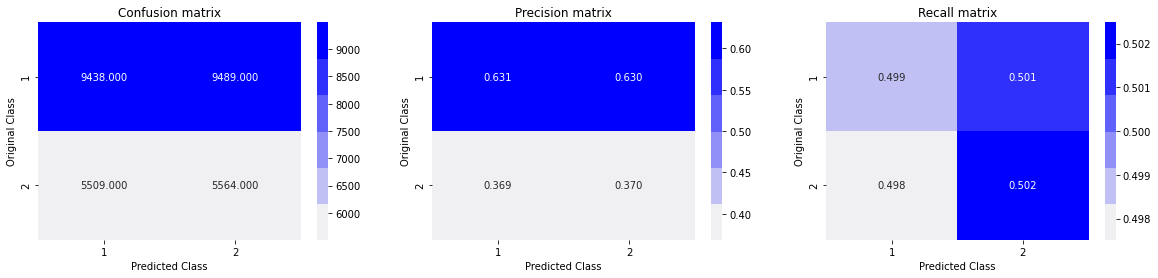

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

train_len = len(y_tr_set1)
predicted_y = np.zeros((train_len,2))
for i in range(train_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

loss_tr = log_loss(y_tr_set1, predicted_y, eps=1e-15)
print("Log loss on Train Data using Random Model",log_loss(y_tr_set1, predicted_y, eps=1e-15))

test_len = len(y_test_set1)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

loss_test = log_loss(y_test_set1, predicted_y, eps=1e-15)
print("Log loss on Test Data using Random Model",log_loss(y_test_set1, predicted_y, eps=1e-15))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
from prettytable import PrettyTable
summary = PrettyTable()
summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF_w2v','Random dumb model', "-" , loss_tr, loss_test ])
print(summary)

+------------+-------------------+----------------------+--------------------+--------------------+
| Vectorizer |       Model       | Best Hyperparameters | Log loss on Train  |  Log loss on Test  |
+------------+-------------------+----------------------+--------------------+--------------------+
| TFIDF_w2v  | Random dumb model |          -           | 0.8833498346157036 | 0.8947183969141304 |
+------------+-------------------+----------------------+--------------------+--------------------+


### 9.1.2 on Set2 TFIDF

Log loss on Train Data using Random Model 0.8906247290502589
Log loss on Test Data using Random Model 0.8875593756379377


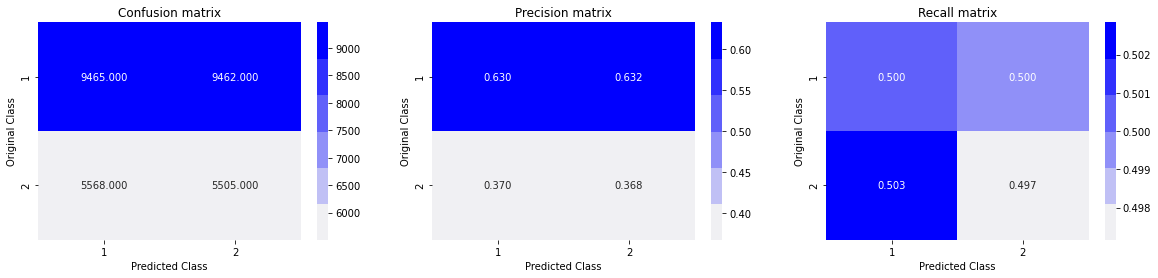

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

train_len = len(y_tr_set2)
predicted_y = np.zeros((train_len,2))
for i in range(train_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

loss_tr = log_loss(y_tr_set2, predicted_y, eps=1e-15)
print("Log loss on Train Data using Random Model",log_loss(y_tr_set2, predicted_y, eps=1e-15))

test_len = len(y_test_set2)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

loss_test = log_loss(y_test_set2, predicted_y, eps=1e-15)
print("Log loss on Test Data using Random Model",log_loss(y_test_set2, predicted_y, eps=1e-15))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
# from prettytable import PrettyTable
# summary = PrettyTable()
summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF','Random dumb model', "-" , loss_tr, loss_test ])
print(summary)

+------------+-------------------+----------------------+--------------------+--------------------+
| Vectorizer |       Model       | Best Hyperparameters | Log loss on Train  |  Log loss on Test  |
+------------+-------------------+----------------------+--------------------+--------------------+
| TFIDF_w2v  | Random dumb model |          -           | 0.8833498346157036 | 0.8947183969141304 |
|   TFIDF    | Random dumb model |          -           | 0.8906247290502589 | 0.8875593756379377 |
+------------+-------------------+----------------------+--------------------+--------------------+


##9.2 Logistic Regression with hyperparameter tuning

In [ ]:
nan_rows = x_tr_set1[x_tr_set1.isnull().any(1)]
nan_rows

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
12888,1,1,1,49,1,9,0.0,10.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.938824,-31.856085,-27.698026,-18.491601,32.933736,-33.358056,10.874426,25.306154,3.096619,-5.448663,35.261578,-34.790535,-51.082086,27.591044,-12.986646,22.735792,15.579580,36.314127,-28.808153,6.756878,36.119309,-13.998691,-21.352034,-12.981033,-12.933090,-32.833954,-44.344798,36.275748,31.564887,18.549893,-5.307683,-16.027183,-22.144691,-5.968166,-39.001328,-33.774124,-23.350083,33.112550,61.547975,17.440058
42525,1,1,1,101,1,16,0.0,17.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.167845,1.833278,-20.409314,-13.829638,17.080634,-5.331939,11.342087,0.194530,12.289283,-28.713551,26.752286,-23.602495,-16.934193,6.595502,-5.332800,38.988239,16.194623,-1.331301,-38.091158,4.555372,32.462463,-36.129028,-24.731949,-8.421738,-11.396000,-25.671741,-7.732469,17.272043,13.572807,-12.185004,-16.409295,4.353818,2.179383,20.211024,-35.896679,-36.532897,-1.673498,22.790662,18.124746,2.562905
44202,1,1,1,144,1,25,0.0,24.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.641090,10.329185,6.051145,-41.716578,10.815285,11.005571,50.515761,46.968002,-11.478936,36.298234,40.943906,-54.780994,-30.976212,1.667883,-8.629835,-3.619613,21.007764,-2.652206,-29.359172,-66.361145,23.323962,-21.629162,-0.786677,9.206473,-4.132074,10.453620,1.923606,-7.983369,27.914912,-8.264179,21.368123,-3.206475,22.419237,46.808369,-38.458466,-2.002794,-5.085982,13.415253,-2.468560,28.391014


In [ ]:
x_tr_set1 = x_tr_set1.dropna()
x_tr_set1.shape

(69996, 218)

In [ ]:
y_new = y_tr_set1[~y_tr_set1.index.isin([12888, 42525, 44202])]
y_tr_set1.shape, y_new.shape

((69999,), (69996,))

In [ ]:
# x = pd.Series(np.random.randn(10))

# x[~x.index.isin([0, 3, 4])]

In [ ]:
y_tr_set1 = y_tr_set1[~y_tr_set1.index.isin([12888, 42525, 44202])]
y_tr_set1.shape

(69996,)

In [ ]:
nan_rows = x_test_set1[x_test_set1.isnull().any(1)]
nan_rows

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
15264,1,1,3,27,1,7,0.0,7.0,0.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.685362,13.367777,-7.510453,-26.587908,43.68527,-1.999349,1.852261,19.991961,-15.744135,-20.924361,-0.896224,14.98661,4.985564,-2.120975,-0.811008,46.830019,2.162738,-1.108611,-23.417459,3.955278,3.630202,-10.735258,-8.379925,14.132031,20.088734,-14.931429,30.62086,-8.436508,-0.244333,-14.009614,14.340215,17.09058,-2.925551,-22.03877,-36.091067,-10.135001,-13.977079,19.101363,3.909252,3.765395
18857,2,1,117,1,19,1,0.0,19.0,0.0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,31.225021,4.309887,70.953063,-29.451086,43.472485,31.062418,5.913258,18.556849,-11.010602,77.25148,8.800784,14.29967,-33.225833,8.032704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x_test_set1 = x_test_set1.dropna()
x_test_set1.shape

(29998, 218)

In [ ]:
y_test_set1.shape

(30000,)

In [ ]:
y_test_set1 = y_test_set1[~y_test_set1.index.isin([15264, 18857])]
y_test_set1.shape

(29998,)

### 9.2.1 on Set1 TFIDF-W2V

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_test = []
log_error_tr = []

for c,i in enumerate(alpha):
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(x_tr_set1, y_tr_set1)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_tr_set1, y_tr_set1)

  predict_y = sig_clf.predict_proba(x_tr_set1)
  log_error_tr.append(log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15))

  predict_y = sig_clf.predict_proba(x_test_set1)
  log_error_test.append(log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15))
  print("="*40)
  print('values of alpha = ', i)
  print( "The Train log loss is:", log_error_tr[c])
  print( "The Test log loss is:", log_error_test[c])



values of alpha =  1e-05
The Train log loss is: 0.4907153880331583
The Test log loss is: 0.4902056511725659
values of alpha =  0.0001
The Train log loss is: 0.47980674855539035
The Test log loss is: 0.47931710383554105
values of alpha =  0.001
The Train log loss is: 0.4888182450881298
The Test log loss is: 0.48818128704155267
values of alpha =  0.01
The Train log loss is: 0.46962625761654014
The Test log loss is: 0.47001584782064615
values of alpha =  0.1
The Train log loss is: 0.4884498345161846
The Test log loss is: 0.4881720180107029
values of alpha =  1
The Train log loss is: 0.5194961319663042
The Test log loss is: 0.5202837095195314
values of alpha =  10
The Train log loss is: 0.5610212336132252
The Test log loss is: 0.562124820226882


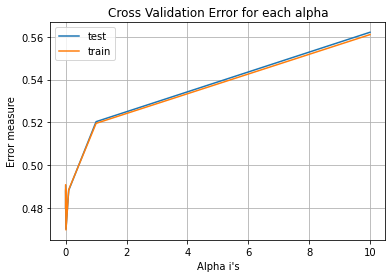

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_test, label="test")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

ax.plot(alpha, log_error_tr, label="train")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_test)
alpha[best_alpha]

0.01

For values of best alpha =  0.01 The train log loss is: 0.46962625761654014
For values of best alpha =  0.01 The test log loss is: 0.47001584782064615
Total number of data points : 29998


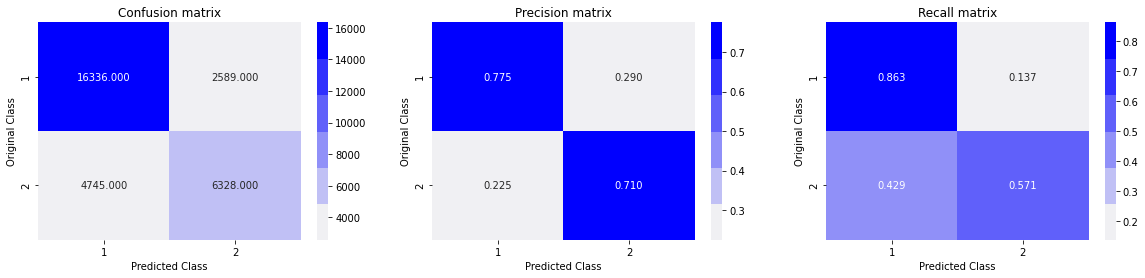

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_tr_set1, y_tr_set1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_tr_set1, y_tr_set1)

predict_y = sig_clf.predict_proba(x_tr_set1)
loss_tr = log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(x_test_set1)
loss_test = log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test_set1, predicted_y)

In [ ]:
# summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF_w2v', 'Logistic Regression by iterative search', "alpha = " + str(alpha[best_alpha]) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+----------------------+---------------------+---------------------+
| Vectorizer |                  Model                  | Best Hyperparameters |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+----------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |          -           |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |          -           |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |     alpha = 0.01     | 0.46962625761654014 | 0.47001584782064615 |
+------------+-----------------------------------------+----------------------+---------------------+---------------------+


### 9.2.2 on Set2 TFIDF

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_test = []
log_error_tr = []

for c,i in enumerate(alpha):
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(x_tr_set2, y_tr_set2)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_tr_set2, y_tr_set2)

  predict_y = sig_clf.predict_proba(x_tr_set2)
  log_error_tr.append(log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15))

  predict_y = sig_clf.predict_proba(x_test_set2)
  log_error_test.append(log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15))
  print("="*40)
  print('values of alpha = ', i)
  print( "The Train log loss is:", log_error_tr[c])
  print( "The Test log loss is:", log_error_test[c])



values of alpha =  1e-05
The Train log loss is: 0.47648366524280994
The Test log loss is: 0.47649648448098414
values of alpha =  0.0001
The Train log loss is: 0.48788971415554827
The Test log loss is: 0.4878077820202616
values of alpha =  0.001
The Train log loss is: 0.4926912855403442
The Test log loss is: 0.49251241661046663
values of alpha =  0.01
The Train log loss is: 0.47447913059529645
The Test log loss is: 0.47492492592180946
values of alpha =  0.1
The Train log loss is: 0.49431003298725923
The Test log loss is: 0.49469649793779014
values of alpha =  1
The Train log loss is: 0.5337075651658262
The Test log loss is: 0.5346974237035389
values of alpha =  10
The Train log loss is: 0.5852285805145416
The Test log loss is: 0.58654016591798


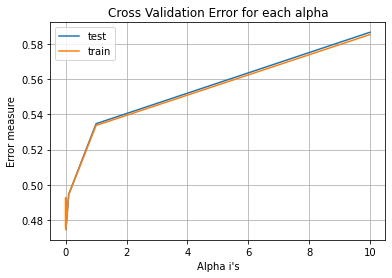

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_test, label="test")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

ax.plot(alpha, log_error_tr, label="train")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_test)
alpha[best_alpha]

0.01

For values of best alpha =  0.01 The train log loss is: 0.47447913059529645
For values of best alpha =  0.01 The test log loss is: 0.47492492592180946
Total number of data points : 30000


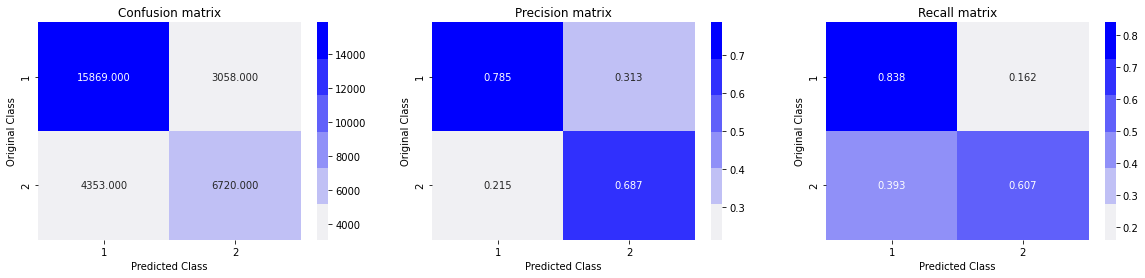

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_tr_set2, y_tr_set2)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_tr_set2, y_tr_set2)

predict_y = sig_clf.predict_proba(x_tr_set2)
loss_tr = log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(x_test_set2)
loss_test = log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test_set2, predicted_y)

In [ ]:
# summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF', 'Logistic Regression by iterative search', "alpha = " + str(alpha[best_alpha]) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+----------------------+---------------------+---------------------+
| Vectorizer |                  Model                  | Best Hyperparameters |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+----------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |          -           |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |          -           |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |     alpha = 0.01     | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |     alpha = 0.01     | 0.47447913059529645 | 0.47492492592180946 |
+------------+-----------------------------------------+----------------------+---------------------+---------------------+


##9.3 Linear SVM with hyperparameter tuning

### 9.3.1 on Set1 TFIDF-W2V

#### 9.3.1.1 using L1 regularizer

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_test = []
log_error_tr = []

for c,i in enumerate(alpha):
  clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
  clf.fit(x_tr_set1, y_tr_set1)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_tr_set1, y_tr_set1)

  predict_y = sig_clf.predict_proba(x_tr_set1)
  log_error_tr.append(log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15))

  predict_y = sig_clf.predict_proba(x_test_set1)
  log_error_test.append(log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15))
  print("="*40)
  print('values of alpha = ', i)
  print( "The Train log loss is:", log_error_tr[c])
  print( "The Test log loss is:", log_error_test[c])



values of alpha =  1e-05
The Train log loss is: 0.5262289807801588
The Test log loss is: 0.5273915604117417
values of alpha =  0.0001
The Train log loss is: 0.5522632788734835
The Test log loss is: 0.5533633430570499
values of alpha =  0.001
The Train log loss is: 0.5507886903685009
The Test log loss is: 0.5521877425808175
values of alpha =  0.01
The Train log loss is: 0.5279639951860344
The Test log loss is: 0.5279033447054262
values of alpha =  0.1
The Train log loss is: 0.5763971467446405
The Test log loss is: 0.5783855333299831
values of alpha =  1
The Train log loss is: 0.6165185184198209
The Test log loss is: 0.616959262569353
values of alpha =  10
The Train log loss is: 0.6412002546134313
The Test log loss is: 0.6407749270399553


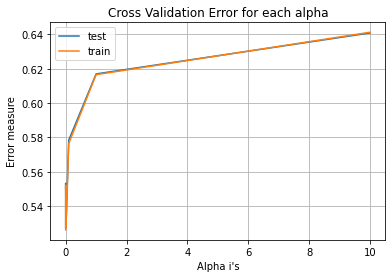

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_test, label="test")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

ax.plot(alpha, log_error_tr, label="train")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_test)
alpha[best_alpha]

1e-05

For values of best alpha =  1e-05 The train log loss is: 0.5262289807801588
For values of best alpha =  1e-05 The test log loss is: 0.5273915604117417
Total number of data points : 29998


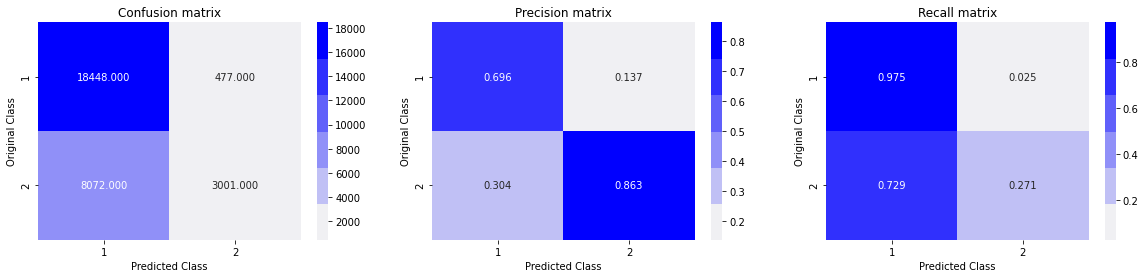

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_tr_set1, y_tr_set1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_tr_set1, y_tr_set1)

predict_y = sig_clf.predict_proba(x_tr_set1)
loss_tr = log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(x_test_set1)
loss_test = log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test_set1, predicted_y)

In [ ]:
# summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF_w2v', 'Linear SVM by iterative search', "L1 Norm & alpha = " + str(alpha[best_alpha]) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |   Best Hyperparameters  |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |            -            |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |            -            |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |       alpha = 0.01      | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |       alpha = 0.01      | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear SVM by iterative search     | L1 Norm & alpha = 1e-05 |  0.5262289807801588 |  0.527

#### 9.3.1.2 using L2 regularizer

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_test = []
log_error_tr = []

for c,i in enumerate(alpha):
  clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
  clf.fit(x_tr_set1, y_tr_set1)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_tr_set1, y_tr_set1)

  predict_y = sig_clf.predict_proba(x_tr_set1)
  log_error_tr.append(log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15))

  predict_y = sig_clf.predict_proba(x_test_set1)
  log_error_test.append(log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15))
  print("="*40)
  print('values of alpha = ', i)
  print( "The Train log loss is:", log_error_tr[c])
  print( "The Test log loss is:", log_error_test[c])



values of alpha =  1e-05
The Train log loss is: 0.47633130866768175
The Test log loss is: 0.4763552298835263
values of alpha =  0.0001
The Train log loss is: 0.48465521019688745
The Test log loss is: 0.48379156402303053
values of alpha =  0.001
The Train log loss is: 0.48461846752390564
The Test log loss is: 0.48398687844394556
values of alpha =  0.01
The Train log loss is: 0.46871366012683224
The Test log loss is: 0.4686366314719216
values of alpha =  0.1
The Train log loss is: 0.4865003201829006
The Test log loss is: 0.4868918830846421
values of alpha =  1
The Train log loss is: 0.5193870816397139
The Test log loss is: 0.5198036614698337
values of alpha =  10
The Train log loss is: 0.5563959592111729
The Test log loss is: 0.5573557292942791


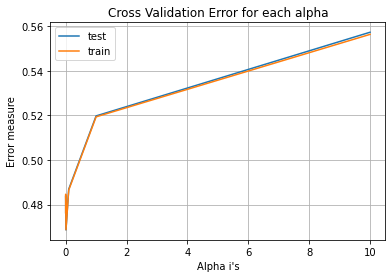

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_test, label="test")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

ax.plot(alpha, log_error_tr, label="train")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_test)
alpha[best_alpha]

0.01

For values of best alpha =  0.01 The train log loss is: 0.5279639951860344
For values of best alpha =  0.01 The test log loss is: 0.5279033447054262
Total number of data points : 29998


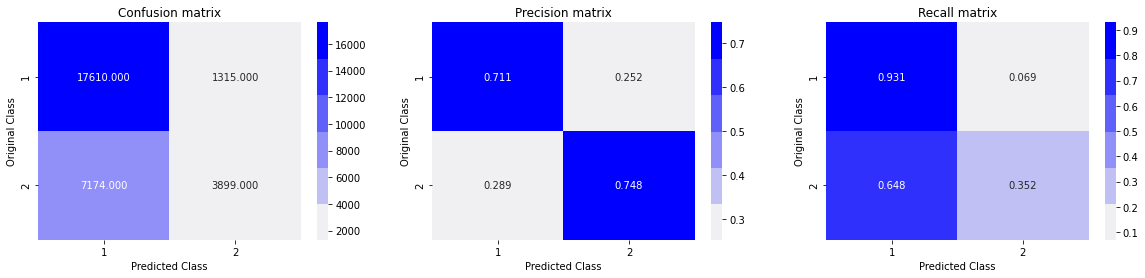

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_tr_set1, y_tr_set1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_tr_set1, y_tr_set1)

predict_y = sig_clf.predict_proba(x_tr_set1)
loss_tr = log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr_set1, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(x_test_set1)
loss_test = log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_set1, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test_set1, predicted_y)

In [ ]:
# summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF_w2v', 'Linear SVM by iterative search', "L2 Norm & alpha = " + str(alpha[best_alpha]) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |   Best Hyperparameters  |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |            -            |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |            -            |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |       alpha = 0.01      | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |       alpha = 0.01      | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear SVM by iterative search     | L1 Norm & alpha = 1e-05 |  0.5262289807801588 |  0.527

### 9.3.2 on Set2 TFIDF

#### 9.3.2.1 using L1 regularizer

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_test = []
log_error_tr = []

for c,i in enumerate(alpha):
  clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
  clf.fit(x_tr_set2, y_tr_set2)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_tr_set2, y_tr_set2)

  predict_y = sig_clf.predict_proba(x_tr_set2)
  log_error_tr.append(log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15))

  predict_y = sig_clf.predict_proba(x_test_set2)
  log_error_test.append(log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15))
  print("="*40)
  print('values of alpha = ', i)
  print( "The Train log loss is:", log_error_tr[c])
  print( "The Test log loss is:", log_error_test[c])



values of alpha =  1e-05
The Train log loss is: 0.4617444825355313
The Test log loss is: 0.4611244032546095
values of alpha =  0.0001
The Train log loss is: 0.49058420708422495
The Test log loss is: 0.49049071419897894
values of alpha =  0.001
The Train log loss is: 0.5537194279204125
The Test log loss is: 0.5542871331535951
values of alpha =  0.01
The Train log loss is: 0.5269012866722299
The Test log loss is: 0.5279991528669492
values of alpha =  0.1
The Train log loss is: 0.5152590327636027
The Test log loss is: 0.5140115117518513
values of alpha =  1
The Train log loss is: 0.6356389372214244
The Test log loss is: 0.6365965176428124
values of alpha =  10
The Train log loss is: 0.5735513368773258
The Test log loss is: 0.5733509959250905


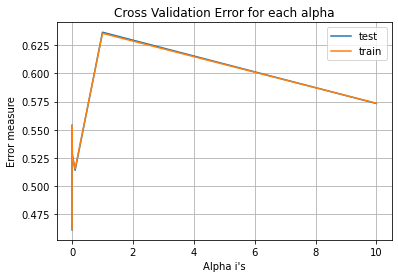

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_test, label="test")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

ax.plot(alpha, log_error_tr, label="train")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_test)
alpha[best_alpha]

1e-05

For values of best alpha =  1e-05 The train log loss is: 0.4617444825355313
For values of best alpha =  1e-05 The test log loss is: 0.4611244032546095
Total number of data points : 30000


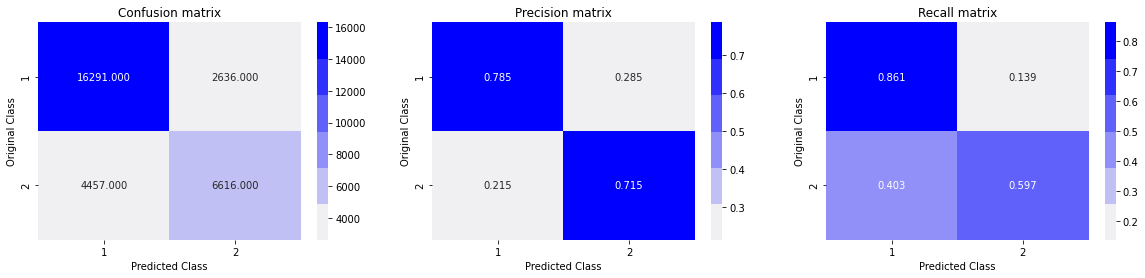

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_tr_set2, y_tr_set2)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_tr_set2, y_tr_set2)

predict_y = sig_clf.predict_proba(x_tr_set2)
loss_tr = log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(x_test_set2)
loss_test = log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test_set2, predicted_y)

In [ ]:
# summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF', 'Linear SVM by iterative search', "L1 Norm & alpha = " + str(alpha[best_alpha]) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |   Best Hyperparameters  |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |            -            |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |            -            |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |       alpha = 0.01      | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |       alpha = 0.01      | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear SVM by iterative search     | L1 Norm & alpha = 1e-05 |  0.5262289807801588 |  0.527

#### 9.3.2.2 using L2 regularizer

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_test = []
log_error_tr = []

for c,i in enumerate(alpha):
  clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
  clf.fit(x_tr_set2, y_tr_set2)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_tr_set2, y_tr_set2)

  predict_y = sig_clf.predict_proba(x_tr_set2)
  log_error_tr.append(log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15))

  predict_y = sig_clf.predict_proba(x_test_set2)
  log_error_test.append(log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15))
  print("="*40)
  print('values of alpha = ', i)
  print( "The Train log loss is:", log_error_tr[c])
  print( "The Test log loss is:", log_error_test[c])



values of alpha =  1e-05
The Train log loss is: 0.4758172712479401
The Test log loss is: 0.47579836592173763
values of alpha =  0.0001
The Train log loss is: 0.4902986991112009
The Test log loss is: 0.49009301454550197
values of alpha =  0.001
The Train log loss is: 0.4905615264605462
The Test log loss is: 0.4904031586038612
values of alpha =  0.01
The Train log loss is: 0.4725183685844193
The Test log loss is: 0.47285000247877945
values of alpha =  0.1
The Train log loss is: 0.4853660554222457
The Test log loss is: 0.4857891982502648
values of alpha =  1
The Train log loss is: 0.5282143476515211
The Test log loss is: 0.5291108443546214
values of alpha =  10
The Train log loss is: 0.5773927144571714
The Test log loss is: 0.5789315994900849


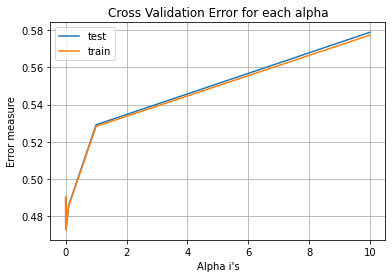

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_test, label="test")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

ax.plot(alpha, log_error_tr, label="train")
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_test)
alpha[best_alpha]

0.01

For values of best alpha =  0.01 The train log loss is: 0.5269012866722299
For values of best alpha =  0.01 The test log loss is: 0.5279991528669492
Total number of data points : 30000


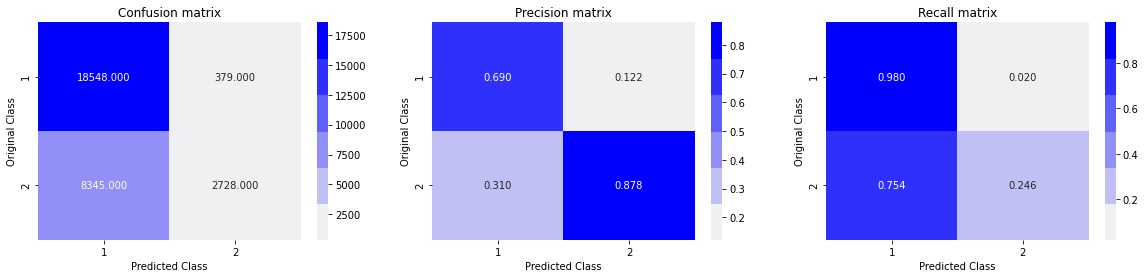

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_tr_set2, y_tr_set2)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_tr_set2, y_tr_set2)

predict_y = sig_clf.predict_proba(x_tr_set2)
loss_tr = log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr_set2, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(x_test_set2)
loss_test = log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_set2, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test_set2, predicted_y)

In [ ]:
# summary.field_names = ["Vectorizer", "Model", "Best Hyperparameters", "Log loss on Train", "Log loss on Test"]
summary.add_row(['TFIDF', 'Linear SVM by iterative search', "L2 Norm & alpha = " + str(alpha[best_alpha]) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |   Best Hyperparameters  |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |            -            |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |            -            |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |       alpha = 0.01      | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |       alpha = 0.01      | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear SVM by iterative search     | L1 Norm & alpha = 1e-05 |  0.5262289807801588 |  0.527

##9.4 XGBoost

### 9.4.1 on set1 TFIDF-W2V

In [ ]:
# https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
xgb_clf = xgb.XGBClassifier()

parameters = {'objective' : ['binary:logistic'],  'eval_metric' : ['logloss'],
        'max_depth': [1,2,3,4],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
         }
d_train = xgb.DMatrix(x_tr_set1, label=y_tr_set1)
d_test = xgb.DMatrix(x_test_set1, label=y_test_set1)

watchlist = [(d_train, 'train'), (d_test, 'valid')]




In [ ]:
clf = GridSearchCV(xgb_clf, parameters, n_jobs = -1, 
                   cv=3, 
                   scoring='neg_log_loss',
                   verbose=2, refit=True)

In [ ]:
clf.fit(x_tr_set1, y_tr_set1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 48.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eval_metric': ['logloss'],
                         'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
                         'max_depth': [1, 2, 3, 4],
 

In [ ]:
for param_name in sorted(clf.best_params_.keys()):
    print((param_name, clf.best_params_[param_name]))

('eval_metric', 'logloss')
('learning_rate', 0.2)
('max_depth', 4)
('objective', 'binary:logistic')


In [ ]:
best_lr = clf.best_params_['learning_rate']
best_max_depth = clf.best_params_['max_depth']

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['learning_rate'] = best_lr
params['max_depth'] = best_max_depth

d_train = xgb.DMatrix(x_tr_set1, label=y_tr_set1)
d_test = xgb.DMatrix(x_test_set1, label=y_test_set1)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_tr_set1,y_tr_set1)
predict_y = bst.predict(d_test)


[0]	train-logloss:0.624393	valid-logloss:0.624138
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.432612	valid-logloss:0.433462
[20]	train-logloss:0.403316	valid-logloss:0.406789
[30]	train-logloss:0.390097	valid-logloss:0.396095
[40]	train-logloss:0.381465	valid-logloss:0.38986
[50]	train-logloss:0.37297	valid-logloss:0.384626
[60]	train-logloss:0.365808	valid-logloss:0.380938
[70]	train-logloss:0.36009	valid-logloss:0.378238
[80]	train-logloss:0.354595	valid-logloss:0.376899
[90]	train-logloss:0.350625	valid-logloss:0.37607
[100]	train-logloss:0.345513	valid-logloss:0.374499
[110]	train-logloss:0.340059	valid-logloss:0.372753
[120]	train-logloss:0.336165	valid-logloss:0.372127
[130]	train-logloss:0.331858	valid-logloss:0.370695
[140]	train-logloss:0.328184	valid-logloss:0.370005
[150]	train-logloss:0.32427	valid-logloss:0.369202
[160]	train-logloss:0.31969	valid

In [ ]:
print("The test log loss is:",log_loss(y_test_set1, predict_y,  eps=1e-15))

The test log loss is: 0.3641260262376425


Total number of data points : 29998


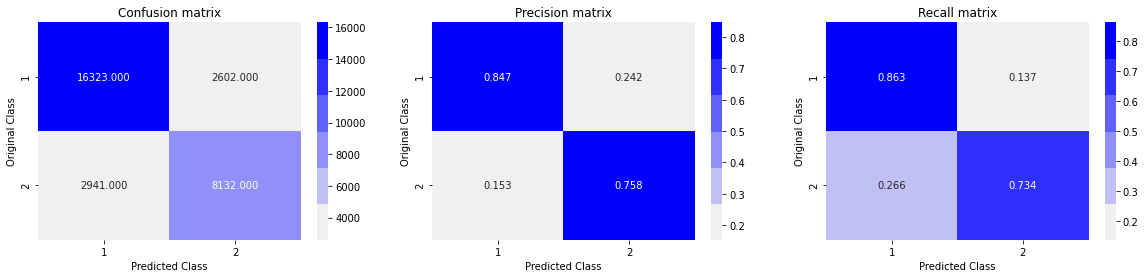

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_set1, predicted_y)

In [ ]:
predict_y = bst.predict(d_train)
loss_tr = log_loss(y_tr_set1, predict_y,  eps=1e-15)
predict_y = bst.predict(d_test)
loss_test = log_loss(y_test_set1, predict_y,  eps=1e-15)

In [ ]:
summary.add_row(['TFIDF_w2v', 'XGBoost by GridSearchCV', 'learning_rate = '+str(best_lr)+' & max_depth = '+str(best_max_depth) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+-------------------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |         Best Hyperparameters        |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |                  -                  |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |                  -                  |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |             alpha = 0.01            | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |             alpha = 0.01            | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear 

### 9.4.2 on set2 TFIDF

In [ ]:
# https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
xgb_clf = xgb.XGBClassifier()

parameters = {'objective' : ['binary:logistic'],  'eval_metric' : ['logloss'],
        'max_depth': [1,2,3,4],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
         }
d_train = xgb.DMatrix(x_tr_set2, label=y_tr_set2)
d_test = xgb.DMatrix(x_test_set2, label=y_test_set2)

watchlist = [(d_train, 'train'), (d_test, 'valid')]




In [ ]:
clf = GridSearchCV(xgb_clf, parameters, n_jobs = -1, 
                   cv=3, 
                   scoring='neg_log_loss',
                   verbose=2, refit=True)

In [ ]:
clf.fit(x_tr_set2, y_tr_set2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 18.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eval_metric': ['logloss'],
                         'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
                         'max_depth': [1, 2, 3, 4],
 

In [ ]:
for param_name in sorted(clf.best_params_.keys()):
    print((param_name, clf.best_params_[param_name]))

('eval_metric', 'logloss')
('learning_rate', 0.2)
('max_depth', 4)
('objective', 'binary:logistic')


In [ ]:
best_lr = clf.best_params_['learning_rate']
best_max_depth = clf.best_params_['max_depth']

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['learning_rate'] = best_lr
params['max_depth'] = best_max_depth

d_train = xgb.DMatrix(x_tr_set2, label=y_tr_set2)
d_test = xgb.DMatrix(x_test_set2, label=y_test_set2)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_tr_set2,y_tr_set2)
predict_y = bst.predict(d_test)


[0]	train-logloss:0.624283	valid-logloss:0.624024
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.432505	valid-logloss:0.433367
[20]	train-logloss:0.404014	valid-logloss:0.4069
[30]	train-logloss:0.390337	valid-logloss:0.395281
[40]	train-logloss:0.380344	valid-logloss:0.387415
[50]	train-logloss:0.374247	valid-logloss:0.383137
[60]	train-logloss:0.367929	valid-logloss:0.378576
[70]	train-logloss:0.36388	valid-logloss:0.376095
[80]	train-logloss:0.359662	valid-logloss:0.373669
[90]	train-logloss:0.356527	valid-logloss:0.372311
[100]	train-logloss:0.351797	valid-logloss:0.369972
[110]	train-logloss:0.348943	valid-logloss:0.368527
[120]	train-logloss:0.345994	valid-logloss:0.367346
[130]	train-logloss:0.343318	valid-logloss:0.366339
[140]	train-logloss:0.340751	valid-logloss:0.365624
[150]	train-logloss:0.33799	valid-logloss:0.364284
[160]	train-logloss:0.336035	val

In [ ]:
print("The test log loss is:",log_loss(y_test_set2, predict_y,  eps=1e-15))

The test log loss is: 0.35556229237499876


Total number of data points : 30000


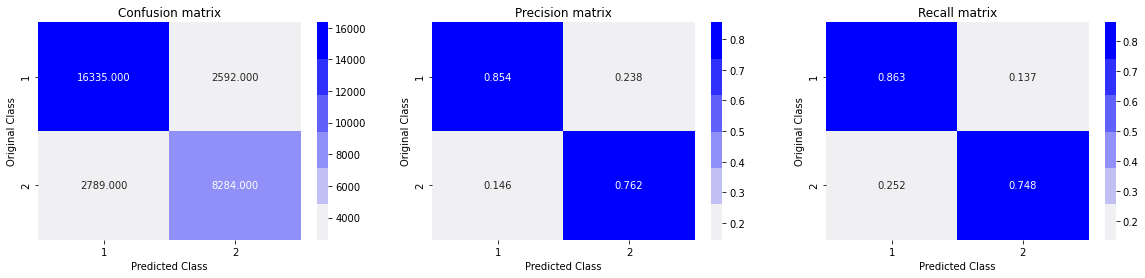

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_set2, predicted_y)

In [ ]:
predict_y = bst.predict(d_train)
loss_tr = log_loss(y_tr_set2, predict_y,  eps=1e-15)
predict_y = bst.predict(d_test)
loss_test = log_loss(y_test_set2, predict_y,  eps=1e-15)

In [ ]:
summary.add_row(['TFIDF', 'XGBoost by GridSearchCV', 'learning_rate = '+str(best_lr)+' & max_depth = '+str(best_max_depth) , loss_tr, loss_test ])
print(summary)

+------------+-----------------------------------------+-------------------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |         Best Hyperparameters        |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |                  -                  |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |                  -                  |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |             alpha = 0.01            | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |             alpha = 0.01            | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear 

#10.Conclusion

In [ ]:
print(summary)

+------------+-----------------------------------------+-------------------------------------+---------------------+---------------------+
| Vectorizer |                  Model                  |         Best Hyperparameters        |  Log loss on Train  |   Log loss on Test  |
+------------+-----------------------------------------+-------------------------------------+---------------------+---------------------+
| TFIDF_w2v  |            Random dumb model            |                  -                  |  0.8833498346157036 |  0.8947183969141304 |
|   TFIDF    |            Random dumb model            |                  -                  |  0.8906247290502589 |  0.8875593756379377 |
| TFIDF_w2v  | Logistic Regression by iterative search |             alpha = 0.01            | 0.46962625761654014 | 0.47001584782064615 |
|   TFIDF    | Logistic Regression by iterative search |             alpha = 0.01            | 0.47447913059529645 | 0.47492492592180946 |
| TFIDF_w2v  |      Linear 

#11.Observations and in detail Summary

1. From EDA of the data we observed that:
  - The dataset is imbalanced with 63-37% approx to non duplicate to duplicate question pairs
  - There is very less percentage of Unique question being repeated.
  - There are no repeated questions pairs in Dataset.
  - There are no NULL entries.
2. Basic Feature Engineering
  - We created 11 Features before preprocessing the data and observed the following:
      *  There are quite a lot of questions with high word similarity
      * The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)  
      * The distributions of the word_Common feature in similar and non-similar questions are highly overlapping
3. Preprocessing of the data
  - Removing html tags
  - Removing Punctuations
  - Performing stemming
  - Removing Stopwords
  - Expanding contractions etc.
4. Advance Feature Engineering
  - We created 15 Advance Features after preprocessing the data and observed the following:
      *  There are few words which occurs frequently in both the cases when the questions are similar and not similiar.
      * From the pair plots of few features, It can be observed that there are few non duplcate pairs of questions which are linearly spearable, althought there is a lot of overlapping of distribution as well.  
      * The TSNE plot very well proves the above point that there are few clusters of non duplicate pairs which are not overlapping at all with clusters of duplicate pairs.
      * The TSNE plot also shows that there are majority of clusters of non duplicate pairs which are overlapping with clusters of duplicate pairs.
5. Splitting of Data
  - Data is splitted into 70-30 ratio into Train and Test
6. Featurizing Text Data
  - Created TFIDF for Train and Test data by fitting vectorizer on train data and transforming it on train and test, also limiting the max_fetures to 100.
  - created TFIDF weighted Word to Vec for Train and Test data appropriately.
7. Creating Data ready for Training Models
  - Set1: comprises of all 11 basic features + 15 advance features + 96 features of TFIDF weighted word to vec of Que 1 + 96 features of TFIDF weighted word to vec of Que 2. 
  - Set2: comprises of all 11 basic features + 15 advance features + 100 features of TFIDF of Que 1 + 100 features of TFIDF of Que 2. 
8. Training Models 
  - Random Dumb Model gives log loss of 0.89 and 0.90 on Set1 and Set2 respectively.
  - Logistic Regression works better on Set2 as compared to Set1 Data.
  - Linear SVM works better on Set2 as compared to Set1 Data.
  - XGBoost works marginally better on Set2 as compared to Set1 Data.

    





